To run every part of this notebook successfully, two documents need to be uploaded, which can be found in the github repository. Alternatively, other files can be uploaded, which are renamed accordingly, or the single lines in the code need to be adjusted, where the files are accessed from.

- "berkeley_llm_security-pages-9 copy.jpg"
- "response.markdown"

Furthermore, the OPENAI_API_KEY needs to be set as an environmental variable. Hereby, it is referred to the readme file for instructions.

Some cells might throw an error of token length. It was agreed on leaving these cells in our notebooks to access the code and bring it into use as soon as the models can handle a longer token length.

In [2]:
!pip install gradio requests openai dspy-ai pytesseract pillow tesseract dspy

In [5]:
import gradio as gr
import os
import requests
import json
from openai import OpenAI
import requests
import json
#from SlideFeedbackGenerator import SlideFeedbackGenerator

# Environment variable for API key
os.getenv('OPENAI_API_KEY')
#serper_key = os.getenv('SERPER_API_KEY')



def generate_feedback(input_markdown, category, levelofEducation):
    feedback_generator = SlideFeedbackGenerator(api_key=os.getenv("OPENAI_API_KEY")) # Here you might want to process the markdown to extract relevant text
    # For simplicity, let's assume you pass the entire markdown content
    return feedback_generator.process(input_markdown, category, levelofEducation)

if not api_key:
    raise ValueError("No OpenAI API key found. Make sure the OPENAI_API_KEY environment variable is set.")

client = OpenAI(api_key = api_key)


# Read in markdown content from file under specific path
input_path = 'response.markdown'



with open(input_path, 'r', encoding='utf-8') as file:
        response_markdown = file.read()

input_markdown = response_markdown



def factuality_check(input_markdown):
    response = statementConverter(input_markdown)
    #extract statements and search strings from response
    statements = response["statements"]
    search_strings = response["searchString"]
    while len(statements) != len(search_strings):
        response = statementConverter(input_markdown)
        statements = response["statements"]
        search_strings = response["searchString"]

    response = google_verifier(search_strings)
    formatted_results = format_search_results(response)
    #formatted_results = langchain_verifier(search_strings)
    return verify_statement(statements=statements, search_strings=search_strings, search_results=formatted_results)


def statementConverter(input_markdown):

    response = client.chat.completions.create(
        model="gpt-4-turbo",
        response_format={ "type": "json_object" },
        messages=[
        {"role": "system", "content": """
        You are a machine that is incredibly wise and very considerate and smart at extracting and injecting a context for statements made on a power point slide deck that should be verified.
        Find the statements that are verifiable in the textual markdown content of the slide deck.
        Before you decide take a deep breath and think about it. Be exact in what is really verfiable in a google search and in on the content on the slide.
        First, only answer statements that you find in the context of the slides. Contextualize the statements made on the slide deck if it is not is not self explanatory in a direct quote. No nicities, salutations or confirmations.
        Second, transform each statement in a verifiable google search term.
        Only answer once you have considered every single slide.
        Consider all content and only return the statements as formatted in json following the scheme: {"statements": ["direct quote statement1", "direct quote statement2", "direct quote statement3", ...], "searchString": ["context search string 1", "context search string 3", "context search string 2", ...]}.
        """},


        {"role": "user", "content": f"""User:  Find verifiable statements in the following content and subsequently transform them into concise question google search strings.:
         {input_markdown}

         Assistant:"""}
        ]
    )
    #convert json response to python dictionary
    dict_response = json.loads(response.choices[0].message.content)
    return dict_response

def google_verifier(search_strings):
    formatted_list = [{"q": search_string} for search_string in search_strings]
    #tranform search string into json dumps
    payload = json.dumps(formatted_list)
    google_url = "https://google.serper.dev/search"
    headers = {
    'X-API-KEY': serper_key,
    'Content-Type': 'application/json'
    }
    response = requests.request("POST", google_url, headers=headers, data=payload)
    return(response.text)

def langchain_verifier(search_strings):
    results = []


    llm = openAIlangchain(temperature=0)
    search = GoogleSerperAPIWrapper()
    tools = [
    Tool(
        name="Intermediate Answer",
        func=search.run,
        description="useful for when you need to ask with search"
        )
    ]

    self_ask_with_search = initialize_agent(tools, llm, agent=AgentType.SELF_ASK_WITH_SEARCH, verbose=True)
    for search_string in search_strings:
        #append search results to results list
        results.append(self_ask_with_search.run(search_string))


def format_search_results(data):
    # If data is a string (i.e., JSON formatted), parse it into a dictionary
    if isinstance(data, str):
        data = json.loads(data)
    return data
    results_dict = {}
    for item in data:
        query = item['searchParameters']['q']
        results_list = []

        # Extracting answer box if available
        if 'answerBox' in item:
            results_list.append({
                'title': item['answerBox']['title'],
                'link': item['answerBox']['link'],
                'snippet': item['answerBox']['snippet']
            })

        # Extracting organic results
        if 'organic' in item:
            for result in item['organic']:
                organic_result = {
                    'title': result['title'],
                    'link': result['link'],
                    'snippet': result['snippet']
                }
                results_list.append(organic_result)

        # Adding results to the dictionary under the respective query
        results_dict[query] = results_list
    return results_dict



def verify_statement(statements,search_strings, search_results):
    # Verify statements with google response using ChatGPT
    results = []
    for statement, search_string, search_result in zip(statements, search_strings, search_results):
        response = client.chat.completions.create(
            model="gpt-3.5-turbo-0125",
            response_format={"type": "json_object"},
            messages=[
                {"role": "system", "content": """
                You are a machine that is incredibly wise and very considerate and smart at verifying statements made.
                Check if the statements made are correct in the context of the google search results.
                Before you decide take a deep breath and think about it. Be exact in what is really verifiable based on the google search results.
                Only answer with if the statement could be verified or not. Nothing else. No niceties, salutations or confirmations.
                Consider all the search result context and only return if the statement can be verified by the google search results in json following the scheme: {"verificationResult":"True"} or {"verificationResult":"False"}
                """},
                {"role": "user", "content": f"""User: Verify if the following statement is correct: {statement}

                use the in the following provided search result context:
                {search_result}

                Assistant:"""}
            ]
        )
        content = json.loads(response.choices[0].message.content)

        # Extract the verification result
        results.append({
            "statement": statement,
            "searchString": search_string,
            "verification_result": content["verificationResult"][0]
        })

    jsonresults = json.dumps(results)
    print(jsonresults)
    return jsonresults

with gr.Blocks() as demo:
    with gr.Row():
        category = gr.Dropdown(
            choices=['Business', 'Education'],
            label="Content Category", value="Education"
        )
        category.change(inputs=[category], outputs=[])
        levelofEducation = gr.Dropdown(choices=['High School', 'Undergraduate', 'Graduate', 'PhD'], label="Level of Education of the Audience", value="Undergraduate")
        levelofEducation.change(inputs=[levelofEducation], outputs=[])

    with gr.Row():
        input_markdown = gr.Textbox(label="Input Markdown", value=response_markdown)
        feedback_output = gr.Textbox(label="Feedback Output")
    with gr.Row():
        feedback_button = gr.Button("Generate Feedback")

    feedback_button.click(
        generate_feedback,
        inputs=[input_markdown, category, levelofEducation],
        outputs=[feedback_output]
    )

### metric assessment, n = 10, every combination of content category and level of education at least once, for the same markdown



#with gr.Blocks() as demo:
#    with gr.Row():
#        factuality_button = gr.Button("Check factuality")
#    with gr.Row():
#        factuality_output = gr.Textbox(label="Factuality Output")
#        factuality_input = gr.Textbox(label="Input Markdown", value=response_markdown)
#    factuality_button.click(
#        factuality_check,
#        inputs=[factuality_input],
#        outputs=[factuality_output]
#    )


if __name__ == "__main__":
    demo.launch(share=False)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [6]:
import requests
import os
import json
from collections import defaultdict
import subprocess

prompt_a="""provide a SHORT and concise prescriptive feedback on the slide. Avoid euphemistic feedback, be critical. Use the following question to guide your feedback, check all checkpoints one after the other, even though not all need be applicable to this slide, consider wisely which one to recommend specifically. Do NOT just repeat the checkpoint descriptions. Additionally, if a checkpoint is applicable describe WHY, WHERE and HOW in the slide the checkpoints should be implemented:
                        1. Insert a pictogram. Pictogram insertion can intuitively convey the slide content.
                        2. Add a subheading. Subheading addition makes the audiences convenient to find information.
                        3. Emphasize words. Emphasizing important words enhances a part of a text to make it noticeable.
                        4. Emphasize areas. Emphasizing important areas of the slides helps focus attention.
                        5. Add T1 and T2. Slide title (T1) and slide messages (T2) help the audiences more easily understand the main content of the exposition.
                        6. Use the grid structure. A grid structure helps organize target and comparison items in rows and columns, creating a table-like format.
                        7. Itemize the text. Text itemization is good in terms of readability and organization.
                        8. Add a comment. Comments aid in audiences’ understanding.
                        9. Correct flow. Left-to-right top-to-bottom flow mimics human scanning methods.
                        10. MECE. Mutually exclusive and collectively exhaustive (MECE) objects should be aligned without omissions and duplication to make the slides convincing.
                        11. Consistent formatting. Look for and point out inconsistencies.
                        12. Add an Action Title. Action titles make the audiences understand the key take-away easy and fast."""

prompt_b="""provide a SHORT and concise prescriptive feedback on the slide. Avoid euphemistic feedback, be critical. Use the following question to guide your feedback, check all checkpoints one after the other, even though not all need be applicable to this slide, consider wisely which one to recommend specifically. Do NOT just repeat the checkpoint descriptions. Additionally, if a checkpoint is applicable describe WHY, WHERE and HOW in the slide the checkpoints should be implemented:
                        1. Insert a pictogram. Pictogram insertion can intuitively convey the slide content.
                        2. Add a subheading. Subheading addition makes the audiences convenient to find information.
                        3. Emphasize words. Emphasizing important words enhances a part of a text to make it noticeable.
                        4. Emphasize areas. Emphasizing important areas of the slides helps focus attention.
                        5. Add T1 and T2. Slide title (T1) and slide messages (T2) help the audiences more easily understand the main content of the exposition.
                        6. Use the grid structure. A grid structure helps organize target and comparison items in rows and columns, creating a table-like format.
                        7. Itemize the text. Text itemization is good in terms of readability and organization.
                        8. Add a comment. Comments aid in audiences’ understanding.
                        9. Correct flow. Left-to-right top-to-bottom flow mimics human scanning methods.
                        10. MECE. Mutually exclusive and collectively exhaustive (MECE) objects should be aligned without omissions and duplication to make the slides convincing.
                        11. Consistent formatting. Look for and point out inconsistencies.
                        12. Citation style. Scientific sources are cited consistently via the same citation style."""
class SlideFeedbackGenerator:
    """
    This module generates feedback for slides based on text input.
    """
    def __init__(self, model_name="gpt-4o", api_key=os.getenv("OPENAI_API_KEY")):
        self.model_name = model_name
        self.api_key = api_key


    def process(self, input_text, category, levelofEducation):
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {self.api_key}"
        }
        #dynamic prompting
        prompt = self.get_prompt(category, levelofEducation)

        payload = {
            "model": self.model_name,
            "messages": [{
                "role": "user",
                "content": [{
                    "type": "text",
                    "text": prompt},{
                        "type": "text",
                        "text": input_text}]
            }],
            "max_tokens": 2048
        }
        #nur headers und payload werden an die AI geschickt
        response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload).json()
        try:
            feedback = response['choices'][0]['message']['content']
        except KeyError:
            feedback = "Failed to obtain feedback. Please check the input or try again."
        return feedback

    def get_prompt(self, category, levelofEducation):
        prompts = {
            ('Business', 'High School'): prompt_a,
            ('Business', 'Undergraduate'): prompt_a,
            ('Business', 'Graduate'): prompt_a,
            ('Business', 'PhD'): prompt_a,
            ('Education', 'High School'): prompt_b,
            ('Education', 'Undergraduate'): prompt_b,
            ('Education', 'Graduate'): prompt_b,
            ('Education', 'PhD'): prompt_b
        }
        return prompts.get((category, levelofEducation), "Generic prompt if no specific one found.")
def initialize_cache():
    return defaultdict(list)

def save_feedback_to_cache(cache, category, level, feedback):
    cache[(category, level)].append(feedback)

def git_commands():
    # Check if .git exists and if not, initialize Git repository
    if not os.path.exists('.git'):
        subprocess.run(['git', 'init'])

    # Git add and commit
    subprocess.run(['git', 'add', 'feedback_cache.json'])
    subprocess.run(['git', 'commit', '-m', 'Update feedback cache'])

    # Git push (make sure remote is set up and credentials are configured)
    subprocess.run(['git', 'push', 'origin', 'master'])



def main():
    categories = ['Business', 'Education']
    levels = ['High School', 'Undergraduate', 'Graduate', 'PhD']
    input_path = '/content/response.markdown'

    with open(input_path, 'r', encoding='utf-8') as file:
        input_markdown = file.read()

    feedback_cache = initialize_cache()
    feedback_generator = SlideFeedbackGenerator(api_key=os.getenv("OPENAI_API_KEY"))

    # Generate feedback for each combination at least once
    for category in categories:
        for level in levels:
            feedback = feedback_generator.process(input_markdown, category, level)
            save_feedback_to_cache(feedback_cache, category, level, feedback)

    # Additional runs to make up to 10
    for _ in range(10 - len(categories) * len(levels)):
        category = categories[_ % len(categories)]
        level = levels[_ % len(levels)]
        feedback = feedback_generator.process(input_markdown, category, level)
        save_feedback_to_cache(feedback_cache, category, level, feedback)

    # Prepare the cache to be JSON serializable by converting tuple keys to strings
    serializable_cache = {f"{k[0]}_{k[1]}": v for k, v in feedback_cache.items()}

    # Saving the cache to a file
    try:
        with open('feedback_cache.json', 'w') as f:
            json.dump(serializable_cache, f, indent=4)
            json.dump(print(input_markdown), f, indent=4)
    except IOError as e:
        print(f"Error writing to file: {e}")

    # Perform git operations to commit and push changes
    git_commands()

if __name__ == "__main__":
    main()



Generative AI and ChatGPT: Beyond the Hype\n\nProf. Dr. Jan Marco Leimeister\n\nFrom insight to impact.\n---\nWhy should you care? = 90%\n\n|30%|By 2030, a major blockbuster film will be released with 90% of the film generated by AI|\n|---|---|\n|10%|By 2025, generative AI is expected to account for 10% of all data produced (up from less than 1% in 2021).|\n| |By 2025, outbound marketing messages from large organizations will be synthetically generated (up from less than 2% in 2022).|\n| |Sources: Gartner (2021) and Gartner (2023)|\n\n© Prof. Dr. Jan Marco Leimeister – Institut für Wirtschaftsinformatik (IWI-HSG) St. Gallen\n---\n|Agenda|1. Introduction to Generative AI|\n|---|---|\n| |- Definition and Development of a Generative AI|\n| |- Types of Generative AI, Use Cases and Platforms|\n|2. Latest Application: ChatGPT| |\n| |- Introduction and Use Cases for ChatGPT|\n| |- Constructing Effective Prompts|\n| |- Benefits and Challenges of Using ChatGPT|\n|3. Let\'s get to work!| |\n|4. 

### Minimal Working Example DSPy for Single Slide Feedback Optimization

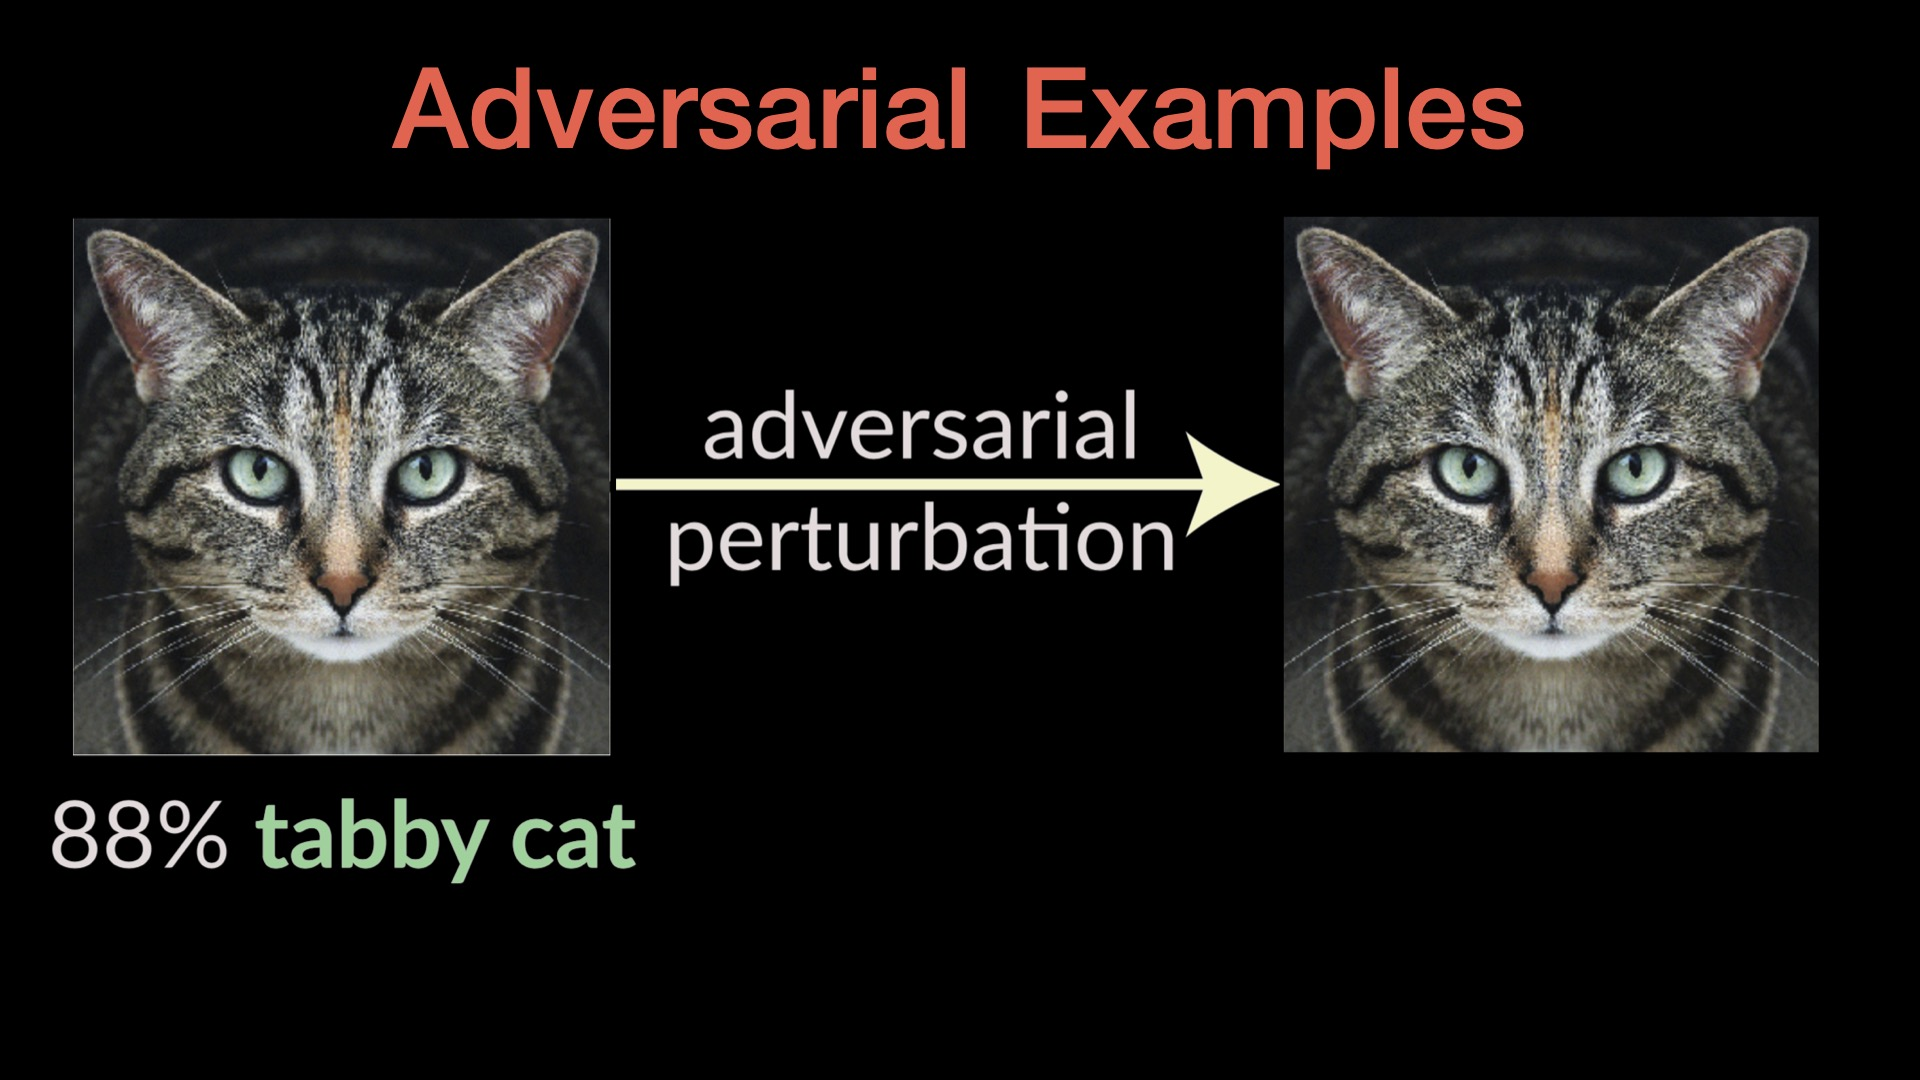

In [7]:
import IPython
def show_img(image_path):
    IPython.display.display(IPython.display.Image(filename=image_path,width=600,height=600))
def print_md(txt):

    IPython.display.display(IPython.display.Markdown(txt))
show_img("/content/berkeley_llm_security-pages-9 copy.jpg")

In [8]:
import inspect
import uuid
from typing import Any

import dsp
import dspy

#################### Assertion Helpers ####################


def _build_error_msg(feedback_msgs):
    """Build an error message from a list of feedback messages."""
    return "\n".join([msg for msg in feedback_msgs])


#################### Assertion Exceptions ####################


class DSPyAssertionError(AssertionError):
    """Custom exception raised when a DSPy `Assert` fails."""

    def __init__(
        self,
        id: str,
        msg: str,
        target_module: Any = None,
        state: Any = None,
        is_metric: bool = False,
    ) -> None:
        super().__init__(msg)
        self.id = id
        self.msg = msg
        self.target_module = target_module
        self.state = state
        self.is_metric = is_metric


class DSPySuggestionError(AssertionError):
    """Custom exception raised when a DSPy `Suggest` fails."""

    def __init__(
        self,
        id: str,
        msg: str,
        target_module: Any = None,
        state: Any = None,
        is_metric: bool = False,
    ) -> None:
        super().__init__(msg)
        self.id = id
        self.msg = msg
        self.target_module = target_module
        self.state = state
        self.is_metric = is_metric


#################### Assertion Primitives ####################


class Constraint:
    def __init__(
        self,
        result: bool,
        msg: str = "",
        target_module=None,
        is_metric: bool = False,
    ):
        self.id = str(uuid.uuid4())
        self.result = result
        self.msg = msg
        self.target_module = target_module
        self.is_metric = is_metric

        self.__call__()


class Assert(Constraint):
    """DSPy Assertion"""

    def __call__(self) -> bool:
        if isinstance(self.result, bool):
            if self.result:
                return True
            elif dspy.settings.bypass_assert:
                dspy.logger.error(f"AssertionError: {self.msg}")
                return True
            else:
                dspy.logger.error(f"AssertionError: {self.msg}")
                raise DSPyAssertionError(
                    id=self.id,
                    msg=self.msg,
                    target_module=self.target_module,
                    state=dsp.settings.trace,
                    is_metric=self.is_metric,
                )
        else:
            raise ValueError("Assertion function should always return [bool]")


class Suggest(Constraint):
    """DSPy Suggestion"""

    def __call__(self) -> Any:
        if isinstance(self.result, bool):
            if self.result:
                return True
            elif dspy.settings.bypass_suggest:
                dspy.logger.info(f"SuggestionFailed: {self.msg}")
                return True
            else:
                dspy.logger.info(f"SuggestionFailed: {self.msg}")
                raise DSPySuggestionError(
                    id=self.id,
                    msg=self.msg,
                    target_module=self.target_module,
                    state=dsp.settings.trace,
                    is_metric=self.is_metric,
                )
        else:
            raise ValueError("Suggestion function should always return [bool]")


#################### Assertion Handlers ####################


def noop_handler(func):
    """Handler to bypass assertions and suggestions.

    Now both assertions and suggestions will become noops.
    """

    def wrapper(*args, **kwargs):
        with dspy.settings.context(bypass_assert=True, bypass_suggest=True):
            return func(*args, **kwargs)

    return wrapper


def bypass_suggest_handler(func):
    """Handler to bypass suggest only.

    If a suggestion fails, it will be logged but not raised.
    And If an assertion fails, it will be raised.
    """

    def wrapper(*args, **kwargs):
        with dspy.settings.context(bypass_suggest=True, bypass_assert=False):
            return func(*args, **kwargs)

    return wrapper


def bypass_assert_handler(func):
    """Handler to bypass assertion only.

    If a assertion fails, it will be logged but not raised.
    And If an assertion fails, it will be raised.
    """

    def wrapper(*args, **kwargs):
        with dspy.settings.context(bypass_assert=True):
            return func(*args, **kwargs)

    return wrapper


def assert_no_except_handler(func):
    """Handler to ignore assertion failure and return None."""

    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except DSPyAssertionError:
            return None

    return wrapper


def backtrack_handler(func, bypass_suggest=True, max_backtracks=2):
    """Handler for backtracking suggestion and assertion.

    Re-run the latest predictor up to `max_backtracks` times,
    with updated signature if an assertion fails. updated signature adds a new
    input field to the signature, which is the feedback.
    """

    def wrapper(*args, **kwargs):
        error_msg, result = None, None
        with dspy.settings.lock:
            dspy.settings.backtrack_to = None
            dspy.settings.suggest_failures = 0
            dspy.settings.assert_failures = 0

            # Predictor -> List[feedback_msg]
            dspy.settings.predictor_feedbacks = {}

            current_error = None
            for i in range(max_backtracks + 1):
                if i > 0 and dspy.settings.backtrack_to is not None:
                    # generate values for new fields
                    feedback_msg = _build_error_msg(
                        dspy.settings.predictor_feedbacks[dspy.settings.backtrack_to],
                    )

                    dspy.settings.backtrack_to_args = {
                        "feedback": feedback_msg,
                        "past_outputs": past_outputs,
                    }

                # if last backtrack: ignore suggestion errors
                if i == max_backtracks:
                    if isinstance(current_error, DSPyAssertionError):
                        raise current_error
                    dsp.settings.trace.clear()
                    result = bypass_suggest_handler(func)(*args, **kwargs) if bypass_suggest else None
                    break
                else:
                    try:
                        dsp.settings.trace.clear()
                        result = func(*args, **kwargs)
                        break
                    except (DSPySuggestionError, DSPyAssertionError) as e:
                        if not current_error:
                            current_error = e
                        error_id, error_msg, error_target_module, error_state = (
                            e.id,
                            e.msg,
                            e.target_module,
                            e.state[-1],
                        )

                        # increment failure count depending on type of error
                        if isinstance(e, DSPySuggestionError) and e.is_metric:
                            dspy.settings.suggest_failures += 1
                        elif isinstance(e, DSPyAssertionError) and e.is_metric:
                            dspy.settings.assert_failures += 1

                        if dsp.settings.trace:
                            if error_target_module:
                                for i in range(len(dsp.settings.trace) - 1, -1, -1):
                                    trace_element = dsp.settings.trace[i]
                                    mod = trace_element[0]
                                    if mod.signature == error_target_module:
                                        error_state = e.state[i]
                                        dspy.settings.backtrack_to = mod
                                        break
                            else:
                                dspy.settings.backtrack_to = dsp.settings.trace[-1][0]

                            if dspy.settings.backtrack_to is None:
                                dspy.logger.error("Specified module not found in trace")

                            # save unique feedback message for predictor
                            if error_msg not in dspy.settings.predictor_feedbacks.setdefault(
                                dspy.settings.backtrack_to,
                                [],
                            ):
                                dspy.settings.predictor_feedbacks[dspy.settings.backtrack_to].append(error_msg)

                            output_fields = error_state[0].new_signature.output_fields
                            past_outputs = {}
                            for field_name in output_fields.keys():
                                past_outputs[field_name] = getattr(
                                    error_state[2],
                                    field_name,
                                    None,
                                )

                            # save latest failure trace for predictor per suggestion
                            error_ip = error_state[1]
                            error_op = error_state[2].__dict__["_store"]
                            error_op.pop("_assert_feedback", None)
                            error_op.pop("_assert_traces", None)

                        else:
                            dspy.logger.error(
                                "UNREACHABLE: No trace available, this should not happen. Is this run time?",
                            )

            return result

    return wrapper


def handle_assert_forward(assertion_handler, **handler_args):
    def forward(self, *args, **kwargs):
        args_to_vals = inspect.getcallargs(self._forward, *args, **kwargs)

        # if user has specified a bypass_assert flag, set it
        if "bypass_assert" in args_to_vals:
            dspy.settings.configure(bypass_assert=args_to_vals["bypass_assert"])

        wrapped_forward = assertion_handler(self._forward, **handler_args)
        return wrapped_forward(*args, **kwargs)

    return forward


default_assertion_handler = backtrack_handler


def assert_transform_module(
    module,
    assertion_handler=default_assertion_handler,
    **handler_args,
):
    """
    Transform a module to handle assertions.
    """
    if not getattr(module, "forward", False):
        raise ValueError(
            "Module must have a forward method to have assertions handled.",
        )
    if getattr(module, "_forward", False):
        dspy.logger.info(
            f"Module {module.__class__.__name__} already has a _forward method. Skipping...",
        )
        pass  # TODO warning: might be overwriting a previous _forward method

    module._forward = module.forward
    module.forward = handle_assert_forward(assertion_handler, **handler_args).__get__(
        module,
    )

    if all(
        map(lambda p: isinstance(p[1], dspy.retry.Retry), module.named_predictors()),
    ):
        pass  # we already applied the Retry mapping outside
    elif all(
        map(lambda p: not isinstance(p[1], dspy.retry.Retry), module.named_predictors()),
    ):
        module.map_named_predictors(dspy.retry.Retry)
    else:
        raise RuntimeError("Module has mixed predictors, can't apply Retry mapping.")

    module._assert_transformed = True

    return module

In [9]:
import random

from pydantic import BaseModel

import dsp
from dspy.predict.parameter import Parameter
from dspy.primitives.prediction import Prediction
from dspy.signatures.signature import ensure_signature, signature_to_template


class Predict(Parameter):
    def __init__(self, signature, **config):
        self.stage = random.randbytes(8).hex()
        self.signature = ensure_signature(signature)
        self.config = config
        self.reset()

    def reset(self):
        self.lm = None
        self.traces = []
        self.train = []
        self.demos = []

    def dump_state(self):
        state_keys = ["lm", "traces", "train"]
        state = {k: getattr(self, k) for k in state_keys}

        state["demos"] = []
        for demo in self.demos:
            demo = demo.copy()

            for field in demo:
                if isinstance(demo[field], BaseModel):
                    demo[field] = demo[field].model_dump_json()

            state["demos"].append(demo)

        # Cache the signature instructions and the last field's name.
        state["signature_instructions"] = self.signature.instructions

        *_, last_key = self.signature.fields.keys()
        state["signature_prefix"] = self.signature.fields[last_key].json_schema_extra["prefix"]

        return state

    def load_state(self, state):
        for name, value in state.items():
            setattr(self, name, value)

        # Reconstruct the signature.
        if "signature_instructions" in state:
            instructions = state["signature_instructions"]
            self.signature = self.signature.with_instructions(instructions)

        if "signature_prefix" in state:
            prefix = state["signature_prefix"]
            *_, last_key = self.signature.fields.keys()
            self.signature = self.signature.with_updated_fields(last_key, prefix=prefix)

    def __call__(self, **kwargs):
        return self.forward(**kwargs)

    def forward(self, **kwargs):
        # Extract the three privileged keyword arguments.
        new_signature = ensure_signature(kwargs.pop("new_signature", None))
        signature = ensure_signature(kwargs.pop("signature", self.signature))
        demos = kwargs.pop("demos", self.demos)
        config = dict(**self.config, **kwargs.pop("config", {}))

        # Get the right LM to use.
        lm = kwargs.pop("lm", self.lm) or dsp.settings.lm
        assert lm is not None, "No LM is loaded."

        # If temperature is 0.0 but its n > 1, set temperature to 0.7.
        temperature = config.get("temperature")
        temperature = lm.kwargs["temperature"] if temperature is None else temperature

        num_generations = config.get("n")
        if num_generations is None:
            num_generations = lm.kwargs.get("n", lm.kwargs.get("num_generations", 1))

        if (temperature is None or temperature <= 0.15) and num_generations > 1:
            config["temperature"] = 0.7
            # print(f"#> Setting temperature to 0.7 since n={num_generations} and prior temperature={temperature}.")

        # All of the other kwargs are presumed to fit a prefix of the signature.
        # That is, they are input variables for the bottom most generation, so
        # we place them inside the input - x - together with the demos.
        x = dsp.Example(demos=demos, **kwargs)

        if new_signature is not None:
            signature = new_signature

        if not all(k in kwargs for k in signature.input_fields):
            present = [k for k in signature.input_fields if k in kwargs]
            missing = [k for k in signature.input_fields if k not in kwargs]
            print(f"WARNING: Not all input fields were provided to module. Present: {present}. Missing: {missing}.")

        # Switch to legacy format for dsp.generate
        template = signature_to_template(signature)

        if self.lm is None:
            x, C = dsp.generate(template, **config)(x, stage=self.stage)
        else:
            # Note: query_only=True means the instructions and examples are not included.
            # I'm not really sure why we'd want to do that, but it's there.
            with dsp.settings.context(lm=self.lm, query_only=True):
                x, C = dsp.generate(template, **config)(x, stage=self.stage)

        assert self.stage in x, "The generated (input, output) example was not stored"

        completions = []

        for c in C:
            completions.append({})
            for field in template.fields:
                if field.output_variable not in kwargs.keys():
                    completions[-1][field.output_variable] = getattr(
                        c,
                        field.output_variable,
                    )

        pred = Prediction.from_completions(completions, signature=signature)

        if kwargs.pop("_trace", True) and dsp.settings.trace is not None:
            trace = dsp.settings.trace
            trace.append((self, {**kwargs}, pred))

        return pred

    def update_config(self, **kwargs):
        self.config = {**self.config, **kwargs}

    def get_config(self):
        return self.config

    def __repr__(self):
        return f"{self.__class__.__name__}({self.signature})"


# TODO: get some defaults during init from the context window?
# # TODO: FIXME: Hmm, I guess expected behavior is that contexts can
# affect execution. Well, we need to determine whether context dominates, __init__ demoninates, or forward dominates.
# Generally, unless overwritten, we'd see n=None, temperature=None.
# That will eventually mean we have to learn them.

In [10]:
import dsp
import dspy
from dspy.signatures.signature import ensure_signature

#import Predict

# TODO: FIXME: Insert this right before the *first* output field. Also rewrite this to use the new signature system.

# TODO: This shouldn't inherit from Predict. It should be a module that has one or two predictors.
# Let's focus on the activated case. It's a predictor with the expanded signature.
# Now, when deactivated, it's a predictor with the original signature.
# When activate is None, though, we need the expanded one but during forward we need to pass the right signature.

"""
class ChainOfThought(dspy.Module):
    def __init__(self, signature):

        input_fields, output_fields = dspy.process_signature(signature)
        output_fields = dict(rationale=dspy.OutputField(prefix="Reasoning: Let's think step by step."), **output_fields)
        self.signature = dspy.Signature(input_fields, output_fields)

        self.predict = dspy.Predict(self.signature)

    def forward(self, **kwargs):
        return self.predict(**kwargs)

# How this should look like. But with also passing signature=simpler_signature to the predict module *if* deactivated.
"""


class ChainOfThought(Predict):
    def __init__(self, signature, rationale_type=None, activated=True, **config):
        super().__init__(signature, **config)

        self.activated = activated

        signature = ensure_signature(self.signature)
        *_keys, last_key = signature.output_fields.keys()

        rationale_type = rationale_type or dspy.OutputField(
            prefix="Reasoning: Let's think step by step in order to",
            desc="${produce the " + last_key + "}. We ...",
        )

        self.extended_signature = signature.prepend("rationale", rationale_type, type_=str)

    def forward(self, **kwargs):
        new_signature = kwargs.pop("new_signature", None)
        if new_signature is None:
            if self.activated is True or (
                self.activated is None and isinstance(dsp.settings.lm, dsp.GPT3)
            ):
                signature = self.extended_signature
            else:
                signature = self.signature
        else:
            signature = new_signature
            # template = dsp.Template(self.signature.instructions, **new_signature)
        return super().forward(signature=signature, **kwargs)


    def dump_state(self):
        state = super().dump_state()

        # Cache the signature instructions and the last field's name.
        state["extended_signature_instructions"] = self.extended_signature.instructions

        *_, last_key = self.signature.fields.keys()
        state["extended_signature_prefix"] = self.extended_signature.fields[last_key].json_schema_extra['prefix']

        return state

    def load_state(self, state):
        super().load_state(state)

        # Reconstruct the signature.
        if "extended_signature_instructions" in state:
            instructions = state["extended_signature_instructions"]
            self.extended_signature = self.extended_signature.with_instructions(instructions)

        if "extended_signature_prefix" in state:
            prefix = state["extended_signature_prefix"]
            *_, last_key = self.extended_signature.fields.keys()
            self.extended_signature = self.extended_signature.with_updated_fields(last_key, prefix=prefix)

"""
TODO: In principle, we can update the field's prefix during forward too to fill any thing based on the input args.

IF the user didn't overwrite our default rationale_type.
"""

"\nTODO: In principle, we can update the field's prefix during forward too to fill any thing based on the input args.\n\nIF the user didn't overwrite our default rationale_type.\n"

In [11]:
import os
import random
import subprocess
import time

import tqdm
import ujson
from datasets.fingerprint import Hasher

import dsp

if os.environ.get('DSP_NOTEBOOK_CACHEDIR'):
    training_data_directory = os.path.join(os.environ.get('DSP_NOTEBOOK_CACHEDIR'), 'compiler')
else:
    training_data_directory = 'cache/compiler'


compilations_assumed_to_exist={'ft-zvEdzQVQ5xwlxvNPrxl6kpnw': 'ada:ft-stanfordpraglab-2023-02-09-19-50-49'}


def openai_check_finetune(jobname):
    if dsp.settings.force_reuse_cached_compilation and jobname in compilations_assumed_to_exist:
        return compilations_assumed_to_exist[jobname]

    command = f"""openai api fine_tunes.get -i {jobname}"""
    print(command)

    result = subprocess.run(command.split(), stdout=subprocess.PIPE, check=False)
    output = result.stdout.decode("utf-8").strip()

    try:
        output = ujson.loads(output)
        if output['status'] == 'succeeded':
            return output['fine_tuned_model']

        if output['status'] in ['pending', 'running']:
            print(f'Compiling, run ```openai api fine_tunes.follow -i {jobname}``` for details...')
            time.sleep(60)
            return openai_check_finetune(jobname)
    except:
        pass

    return False


def convert_to_training_point2(y, inputs, outputs, template):
    assert len(inputs) + len(outputs) == len(template.fields)

    y_ = dsp.Example(**{f: y[f] for f in inputs}, demos=[])
    prompt = template(y_, show_guidelines=False)

    completion = y[outputs[0]]
    output_fields = template.fields[len(inputs):]

    for field in output_fields[1:]:
        completion += f"\n\n{field.name} " + y[field.output_variable]

    completion = " " + completion + " </s>"
    return {'prompt': prompt, 'completion': completion}


def simulate(program, input_examples):
    training_data = []

    for input_example in tqdm.tqdm(input_examples):
        prediction = program(input_example)

        if prediction is not None:
            # assert len(prediction.compiling_stages) == 2, "TMP"
            for stage in prediction.compiling_stages:
                name, template, inputs, outputs = stage['name'], stage['template'], stage['inputs'], stage['outputs']
                training_data.append(convert_to_training_point2(prediction.get(name), inputs, outputs, template))

    r = random.Random(0)
    r.shuffle(training_data)

    return training_data


def openai_finetune_(name, target):
    training_data_path = name_to_path(name)

    # Launch the fine-tune on the path
    command = f"""openai api fine_tunes.create -t {training_data_path} -m {target} --n_epochs 4 --learning_rate_multiplier 0.05 --no_check_if_files_exist"""
    print(command)

    # command = """python script.py"""
    process = subprocess.Popen(command.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    while line := process.stdout.readline().decode().strip():
        if 'created fine-tune:' in line.lower():
            jobname = line.split()[-1]
            break

    #     if 'costs $' in line.lower():
    #         cost = line.split()[-1]
    #         break

    # assert cost[0] == '$'

    # if float(cost[1:]) > 300:
    #     print(f'Got cost {cost} -- you may wanna cancel the job: openai api fine_tunes.cancel -i {jobname}')

    # print(cost)

    print(jobname)

    # Block until it's done
    ft = openai_check_finetune(jobname)
    assert ft, ft

    # Return its name
    return (jobname, ft)


def openai_finetune(name, target):
    print(name)
    training_data_path = name_to_path(name)
    training_data_path += '.model'

    # if path + stuff exists, load the tuple from it
    try:
        with open(training_data_path) as f:
            jobname, ft = ujson.loads(f.readline())

        if openai_check_finetune(jobname):
            return jobname, ft
    except:
        pass

    jobname, ft = openai_finetune_(name, target)

    with open(training_data_path, 'w') as f:
        f.write(ujson.dumps((jobname, ft)) + '\n')

    return jobname, ft


def name_to_path(name):
    if not os.path.exists(training_data_directory):
        os.makedirs(training_data_directory)

    training_data_path = os.path.join(training_data_directory, f'{name}.jsonl')
    return training_data_path


# 3. Check that the output file name has status "success" (not deleted or non-existent). Otherwise, re-call with n = n+1.
def finetune(training_data, target):
    name = Hasher.hash(training_data)
    training_data_path = name_to_path(name)

    with open(training_data_path, 'w') as f:
        for line in training_data:
            f.write(ujson.dumps(line) + '\n')

    jobname, ft = openai_finetune(name, target)
    print(ft)

    ft = dsp.GPT3(model=ft, stop=" </s>")
    return ft

# 4. Return updated program.
def compile(program, examples, target='ada'):
    training_data = simulate(program, examples)
    compiled_lm = finetune(training_data, target=target)

    def compiled_program(*args, **kwargs):
        with dsp.settings.context(compiled_lm=compiled_lm, compiling=False):
            return program(*args, **kwargs)

    compiled_program.lm = compiled_lm
    return compiled_program

In [13]:
!sudo apt update
!sudo apt install tesseract-ocr

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [973 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,125 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://security.ubu

Minimum Viable Working Example for Metric Assessment [do not change]

In [14]:
import pytesseract
from PIL import Image
import dspy
from dspy.teleprompt import BootstrapFewShot
from dspy import Example

turbo = dspy.OpenAI(model='gpt-3.5-turbo-instruct', max_tokens=3687)
dspy.settings.configure(lm=turbo)

class SlideFeedbackGenerator(dspy.Module):
    def __init__(self):
        super().__init__()
        self.prog = dspy.ChainOfThought("slide -> evaluation")

    def forward(self, slide, checkpoints):
        # Define the prompt as specified
        prompt_a = """provide a SHORT and concise prescriptive feedback on the slide. Avoid euphemistic feedback, be critical. Use the following question to guide your feedback, check all checkpoints one after the other, even though not all need be applicable to this slide, consider wisely which one to recommend specifically. Do NOT just repeat the checkpoint descriptions. Additionally, if a checkpoint is applicable describe WHY, WHERE and HOW in the slide the checkpoints should be implemented:
                        1. Insert a pictogram. Pictogram insertion can intuitively convey the slide content.
                        2. Add a subheading. Subheading addition makes the audiences convenient to find information.
                        3. Emphasize words. Emphasizing important words enhances a part of a text to make it noticeable.
                        4. Emphasize areas. Emphasizing important areas of the slides helps focus attention.
                        5. Add T1 and T2. Slide title (T1) and slide messages (T2) help the audiences more easily understand the main content of the exposition.
                        6. Use the grid structure. A grid structure helps organize target and comparison items in rows and columns, creating a table-like format.
                        7. Itemize the text. Text itemization is good in terms of readability and organization.
                        8. Add a comment. Comments aid in audiences’ understanding.
                        9. Correct flow. Left-to-right top-to-bottom flow mimics human scanning methods.
                        10. MECE. Mutually exclusive and collectively exhaustive (MECE) objects should be aligned without omissions and duplication to make the slides convincing.
                        11. Consistent formatting. Look for and point out inconsistencies."""

        # Include the slide content in the prompt
        prompt = f"{prompt_a}\n\nSlide content: {slide}"

        # Generate the output using the program
        output = self.prog(slide=prompt)
        print("Generated Output:", output)  # Debug print
        return output


# Define the less strict assertion to ensure most checkpoints are addressed
# the threshold is not for the relation of how many checkpoints were actually checked but for the numbers of keywords that match in the AI output with the words in the checkpoint itself (in the prompt)
def all_checkpoints_addressed(output, checkpoints, threshold=0.8):
    print("Checking if all checkpoints are addressed...")  # Debug print
    output_text = str(output).lower()  # Convert output to lowercase for case-insensitive matching
    matched_checkpoints = 0
    for checkpoint in checkpoints:
        key_phrases = checkpoint.lower().split()  # Split checkpoint into key phrases
        if any(phrase in output_text for phrase in key_phrases):
            matched_checkpoints += 1
        else:
            print(f"Key phrase from checkpoint not found: {checkpoint}")  # Debug print
    match_ratio = matched_checkpoints / len(checkpoints)
    print(f"Match Ratio: {match_ratio}")  # Debug print
    return match_ratio >= threshold

# Create the DSPy program
slide_evaluator = SlideFeedbackGenerator()

# Read the slide content using OCR
image_path = "/content/berkeley_llm_security-pages-9 copy.jpg"
slide_text = pytesseract.image_to_string(Image.open(image_path))
print("Slide Text:", slide_text)  # Debug print

# Define the checkpoints
checkpoints = [
    "1. Insert a pictogram. Pictogram insertion can intuitively convey the slide content.",
    "2. Add a subheading. Subheading addition makes the audiences convenient to find information.",
    "3. Emphasize words. Emphasizing important words enhances a part of a text to make it noticeable.",
    "4. Emphasize areas. Emphasizing important areas of the slides helps focus attention.",
    "5. Add T1 and T2. Slide title (T1) and slide messages (T2) help the audiences more easily understand the main content of the exposition.",
    "6. Use the grid structure. A grid structure helps organize target and comparison items in rows and columns, creating a table-like format.",
    "7. Itemize the text. Text itemization is good in terms of readability and organization.",
    "8. Add a comment. Comments aid in audiences’ understanding.",
    "9. Correct flow. Left-to-right top-to-bottom flow mimics human scanning methods.",
    "10. MECE. Mutually exclusive and collectively exhaustive (MECE) objects should be aligned without omissions and duplication to make the slides convincing.",
    "11. Consistent formatting. Look for and point out inconsistencies."
]
print("Checkpoints:", checkpoints)  # Debug print

# Apply the assertion
output = slide_evaluator.forward(slide=slide_text, checkpoints=checkpoints)
print("Output:", output)  # Debug print

# Check if most checkpoints are addressed
assertion_result = all_checkpoints_addressed(output, checkpoints, threshold=0.8)
print("Assertion Result:", assertion_result)  # Debug print

# Apply the assertion
try:
    assertion = dspy.Assert(
        result=assertion_result,
        msg="Not all checkpoints were checked.",
        target_module=slide_evaluator
    )
except dspy.DSPyAssertionError as e:
    print(f"Assertion failed: {e.msg}")
    # Handle the failure (e.g., log it, provide feedback, etc.)

# Use BootstrapFewShot to compile the program
teleprompter = BootstrapFewShot(metric=all_checkpoints_addressed)

# Ensure trainset is not empty and properly formatted
trainset = [
    Example(inputs={"slide": "example_slide"}, outputs={"evaluation": "example_evaluation"})
]  # Replace with actual training data
if not trainset:
    print("Trainset is empty. Please provide training data.")
else:
    compiled_program = teleprompter.compile(slide_evaluator, trainset=trainset)

    # Evaluate the program
    result = compiled_program(slide=slide_text, checkpoints=checkpoints)
    print(result)


Slide Text: Adversarial Examples

  

J
adversarial a

perturbation” —

  
  
 

Checkpoints: ['1. Insert a pictogram. Pictogram insertion can intuitively convey the slide content.', '2. Add a subheading. Subheading addition makes the audiences convenient to find information.', '3. Emphasize words. Emphasizing important words enhances a part of a text to make it noticeable.', '4. Emphasize areas. Emphasizing important areas of the slides helps focus attention.', '5. Add T1 and T2. Slide title (T1) and slide messages (T2) help the audiences more easily understand the main content of the exposition.', '6. Use the grid structure. A grid structure helps organize target and comparison items in rows and columns, creating a table-like format.', '7. Itemize the text. Text itemization is good in terms of readability and organization.', '8. Add a comment. Comments aid in audiences’ understanding.', '9. Correct flow. Left-to-right top-to-bottom flow mimics human scanning methods.', '10. MECE. Mu

100%|██████████| 1/1 [00:00<00:00, 2089.84it/s]

Failed to run or to evaluate example Example({'inputs': {'slide': 'example_slide'}, 'outputs': {'evaluation': 'example_evaluation'}}) (input_keys=None) with <function all_checkpoints_addressed at 0x780b37754430> due to Inputs have not been set for this example. Use `example.with_inputs()` to set them..
Bootstrapped 0 full traces after 1 examples in round 0.
Generated Output: Prediction(
    rationale='provide a SHORT and concise prescriptive feedback on the slide. We can start by adding a subheading to make it easier for the audience to find information. Additionally, we should emphasize the words "adversarial examples" to make it more noticeable. We can also use the grid structure to organize the text and add a comment to aid in the audience\'s understanding. Finally, we should check for consistent formatting to ensure the slide is visually appealing and easy to follow.',
    evaluation="The slide could benefit from a subheading, emphasized words, and a grid structure to improve organ

Minimum Viable Example [development version] for checkpoint metric


In [15]:
import pytesseract
from PIL import Image
import dspy
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
from dspy import Example

turbo = dspy.OpenAI(model='gpt-3.5-turbo-instruct', max_tokens=250)
dspy.settings.configure(lm=turbo)

class SlideFeedbackGenerator(dspy.Module):
    def __init__(self):
        super().__init__()
        self.prog = dspy.ChainOfThought("slide -> evaluation")

    def forward(self, slide, checkpoints):
        # Define the prompt as specified
        prompt_a = """provide a SHORT and concise prescriptive feedback on the slide. Avoid euphemistic feedback, be critical. Use the following question to guide your feedback, check all checkpoints one after the other, even though not all need be applicable to this slide, consider wisely which one to recommend specifically. Do NOT just repeat the checkpoint descriptions. Additionally, if a checkpoint is applicable describe WHY, WHERE and HOW in the slide the checkpoints should be implemented:
                        1. Insert a pictogram. Pictogram insertion can intuitively convey the slide content.
                        2. Add a subheading. Subheading addition makes the audiences convenient to find information.
                        3. Emphasize words. Emphasizing important words enhances a part of a text to make it noticeable.
                        4. Emphasize areas. Emphasizing important areas of the slides helps focus attention.
                        5. Add T1 and T2. Slide title (T1) and slide messages (T2) help the audiences more easily understand the main content of the exposition.
                        6. Use the grid structure. A grid structure helps organize target and comparison items in rows and columns, creating a table-like format.
                        7. Itemize the text. Text itemization is good in terms of readability and organization.
                        8. Add a comment. Comments aid in audiences’ understanding.
                        9. Correct flow. Left-to-right top-to-bottom flow mimics human scanning methods.
                        10. MECE. Mutually exclusive and collectively exhaustive (MECE) objects should be aligned without omissions and duplication to make the slides convincing.
                        11. Consistent formatting. Look for and point out inconsistencies."""

        # Include the slide content in the prompt
        prompt = f"{prompt_a}\n\nSlide content: {slide}"

        # Generate the output using the program
        output = self.prog(slide=prompt)
        print("Generated Output:", output)  # Debug print
        return output

# Define the less strict assertion to ensure most checkpoints are addressed
def all_checkpoints_addressed(output, checkpoints, threshold=0.8):
    print("Checking if all checkpoints are addressed...")  # Debug print
    output_text = str(output).lower()  # Convert output to lowercase for case-insensitive matching
    matched_checkpoints = 0
    for checkpoint in checkpoints:
        key_phrases = checkpoint.lower().split()  # Split checkpoint into key phrases
        if any(phrase in output_text for phrase in key_phrases):
            matched_checkpoints += 1
        else:
            print(f"Key phrase from checkpoint not found: {checkpoint}")  # Debug print
    match_ratio = matched_checkpoints / len(checkpoints)
    print(f"Match Ratio: {match_ratio}")  # Debug print
    return match_ratio >= threshold

def save_feedback_to_cache(cache, slide_text, feedback):
    # Assuming feedback is a dictionary or some data structure holding addressed checkpoints
    cache[slide_text].append(feedback)

def calculate_addressed_checkpoints(output, checkpoints):
    output_text = str(output).lower()  # Convert output to lowercase for case-insensitive matching
    addressed_checkpoints = {}
    for checkpoint in checkpoints:
        # Here assuming each checkpoint is a phrase and checking if it's mentioned in the output
        key_phrases = checkpoint.lower().split()  # Example to split checkpoint into words; adjust based on actual data structure
        # Check if all key phrases in checkpoint are found in the output text
        if all(phrase in output_text for phrase in key_phrases):
            addressed_checkpoints[checkpoint] = True
        else:
            addressed_checkpoints[checkpoint] = False
    return addressed_checkpoints

def main():
    # Create the DSPy program
    slide_evaluator = SlideFeedbackGenerator()

    # Read the slide content using OCR
    image_path = "/content/berkeley_llm_security-pages-9 copy.jpg"
    slide_text = pytesseract.image_to_string(Image.open(image_path))
    print("Slide Text:", slide_text)  # Debug print

    # Define the checkpoints
    checkpoints = [
        "1. Insert a pictogram. Pictogram insertion can intuitively convey the slide content.",
        "2. Add a subheading. Subheading addition makes the audiences convenient to find information.",
        "3. Emphasize words. Emphasizing important words enhances a part of a text to make it noticeable.",
        "4. Emphasize areas. Emphasizing important areas of the slides helps focus attention.",
        "5. Add T1 and T2. Slide title (T1) and slide messages (T2) help the audiences more easily understand the main content of the exposition.",
        "6. Use the grid structure. A grid structure helps organize target and comparison items in rows and columns, creating a table-like format.",
        "7. Itemize the text. Text itemization is good in terms of readability and organization.",
        "8. Add a comment. Comments aid in audiences’ understanding.",
        "9. Correct flow. Left-to-right top-to-bottom flow mimics human scanning methods.",
        "10. MECE. Mutually exclusive and collectively exhaustive (MECE) objects should be aligned without omissions and duplication to make the slides convincing.",
        "11. Consistent formatting. Look for and point out inconsistencies."
    ]
    print("Checkpoints:", checkpoints)  # Debug print

    # Initialize feedback cache
    feedback_cache = initialize_cache()

    # Loop 10 times to generate and save unique feedback
    for i in range(10):
        print(f"Run {i+1}:")
        output = slide_evaluator.forward(slide=slide_text, checkpoints=checkpoints)
        print("Output:", output)  # Debug print

        # Extract and save the addressed checkpoints
        addressed_checkpoints = calculate_addressed_checkpoints(output, checkpoints)
        save_feedback_to_cache(feedback_cache, slide_text, addressed_checkpoints)

        assertion_result = all_checkpoints_addressed(output, checkpoints)
        print("Assertion Result:", assertion_result)  # Debug print

    # Compile and evaluate the program
    teleprompter = BootstrapFewShot(metric=all_checkpoints_addressed)
    compiled_program = teleprompter.compile(slide_evaluator, trainset=[Example(inputs={"slide": "example_slide"}, outputs={"evaluation": "example_evaluation"})])
    result = compiled_program(slide=slide_text, checkpoints=checkpoints)
    print("Final Evaluation Result:", result)

    # Save feedback to a file
    serializable_cache = {k: v for k, v in feedback_cache.items()}
    try:
        with open('feedback_cache.json', 'w') as f:
            json.dump(serializable_cache, f, indent=4)
    except IOError as e:
        print(f"Error writing to file: {e}")

    # Git operations
    git_commands()

if __name__ == "__main__":
    main()


Slide Text: Adversarial Examples

  

J
adversarial a

perturbation” —

  
  
 

Checkpoints: ['1. Insert a pictogram. Pictogram insertion can intuitively convey the slide content.', '2. Add a subheading. Subheading addition makes the audiences convenient to find information.', '3. Emphasize words. Emphasizing important words enhances a part of a text to make it noticeable.', '4. Emphasize areas. Emphasizing important areas of the slides helps focus attention.', '5. Add T1 and T2. Slide title (T1) and slide messages (T2) help the audiences more easily understand the main content of the exposition.', '6. Use the grid structure. A grid structure helps organize target and comparison items in rows and columns, creating a table-like format.', '7. Itemize the text. Text itemization is good in terms of readability and organization.', '8. Add a comment. Comments aid in audiences’ understanding.', '9. Correct flow. Left-to-right top-to-bottom flow mimics human scanning methods.', '10. MECE. Mu

100%|██████████| 1/1 [00:00<00:00, 2098.20it/s]

Failed to run or to evaluate example Example({'inputs': {'slide': 'example_slide'}, 'outputs': {'evaluation': 'example_evaluation'}}) (input_keys=None) with <function all_checkpoints_addressed at 0x780b21d1d2d0> due to Inputs have not been set for this example. Use `example.with_inputs()` to set them..
Bootstrapped 0 full traces after 1 examples in round 0.
Generated Output: Prediction(
    rationale='provide a SHORT and concise prescriptive feedback on the slide. We can start by adding a subheading to make it easier for the audience to find information. Additionally, we should emphasize the words "adversarial examples" to make it more noticeable. We can also use the grid structure to organize the text and add a comment to aid in the audience\'s understanding. Finally, we should check for consistent formatting to ensure the slide is visually appealing and easy to follow.',
    evaluation="The slide could benefit from a subheading, emphasized words, and a grid structure to improve organ

Minimum Viable Example [development version] reasoning checkpoint for Berkeley Slide


In [16]:
import pytesseract
from PIL import Image
import dspy
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
from dspy import Example
import json
from collections import defaultdict

turbo = dspy.OpenAI(model='gpt-3.5-turbo-instruct', max_tokens=250)
dspy.settings.configure(lm=turbo)

class SlideFeedbackGenerator(dspy.Module):
    def __init__(self):
        super().__init__()
        self.prog = dspy.ChainOfThought("slide -> evaluation")

    def forward(self, slide, checkpoints):
        # Define the prompt as specified
        prompt_a = """provide a SHORT and concise prescriptive feedback on the slide. Avoid euphemistic feedback, be critical. Use the following question to guide your feedback, check all checkpoints one after the other, even though not all need be applicable to this slide, consider wisely which one to recommend specifically. Do NOT just repeat the checkpoint descriptions. Additionally, if a checkpoint is applicable describe WHY, WHERE and HOW in the slide the checkpoints should be implemented:
                        1. Insert a pictogram. Pictogram insertion can intuitively convey the slide content.
                        2. Add a subheading. Subheading addition makes the audiences convenient to find information.
                        3. Emphasize words. Emphasizing important words enhances a part of a text to make it noticeable.
                        4. Emphasize areas. Emphasizing important areas of the slides helps focus attention.
                        5. Add T1 and T2. Slide title (T1) and slide messages (T2) help the audiences more easily understand the main content of the exposition.
                        6. Use the grid structure. A grid structure helps organize target and comparison items in rows and columns, creating a table-like format.
                        7. Itemize the text. Text itemization is good in terms of readability and organization.
                        8. Add a comment. Comments aid in audiences’ understanding.
                        9. Correct flow. Left-to-right top-to-bottom flow mimics human scanning methods.
                        10. MECE. Mutually exclusive and collectively exhaustive (MECE) objects should be aligned without omissions and duplication to make the slides convincing.
                        11. Consistent formatting. Look for and point out inconsistencies."""

        # Include the slide content in the prompt
        prompt = f"{prompt_a}\n\nSlide content: {slide}"

        # Generate the output using the program
        output = self.prog(slide=prompt)
        print("Generated Output:", output)  # Debug print
        return output

# Define the new metric to check if reasoning is given in the output
def reasoning_given(output, threshold=0.8):
    print("Checking if reasoning is given...")  # Debug print
    output_text = str(output).lower()  # Convert output to lowercase for case-insensitive matching
    reasoning_keywords = ["because", "therefore", "due to", "as a result", "hence", "thus", "since", "so that"]
    reasoning_count = sum(1 for keyword in reasoning_keywords if keyword in output_text)
    print(f"Reasoning Count: {reasoning_count}")  # Debug print
    return reasoning_count > 0

def save_feedback_to_cache(cache, slide_text, feedback):
    # Assuming feedback is a dictionary or some data structure holding addressed checkpoints
    cache[slide_text].append(feedback)

def calculate_addressed_checkpoints(output, checkpoints):
    output_text = str(output).lower()  # Convert output to lowercase for case-insensitive matching
    addressed_checkpoints = {}
    for checkpoint in checkpoints:
        # Here assuming each checkpoint is a phrase and checking if it's mentioned in the output
        key_phrases = checkpoint.lower().split()  # Example to split checkpoint into words; adjust based on actual data structure
        # Check if all key phrases in checkpoint are found in the output text
        if all(phrase in output_text for phrase in key_phrases):
            addressed_checkpoints[checkpoint] = True
        else:
            addressed_checkpoints[checkpoint] = False
    return addressed_checkpoints

def initialize_cache():
    return defaultdict(list)

def git_commands():
    # Placeholder for git operations
    pass

def main():
    # Create the DSPy program
    slide_evaluator = SlideFeedbackGenerator()

    # Read the slide content using OCR
    image_path = "/content/berkeley_llm_security-pages-9 copy.jpg"
    slide_text = pytesseract.image_to_string(Image.open(image_path))
    print("Slide Text:", slide_text)  # Debug print

    # Define the checkpoints
    checkpoints = [
        "1. Insert a pictogram. Pictogram insertion can intuitively convey the slide content.",
        "2. Add a subheading. Subheading addition makes the audiences convenient to find information.",
        "3. Emphasize words. Emphasizing important words enhances a part of a text to make it noticeable.",
        "4. Emphasize areas. Emphasizing important areas of the slides helps focus attention.",
        "5. Add T1 and T2. Slide title (T1) and slide messages (T2) help the audiences more easily understand the main content of the exposition.",
        "6. Use the grid structure. A grid structure helps organize target and comparison items in rows and columns, creating a table-like format.",
        "7. Itemize the text. Text itemization is good in terms of readability and organization.",
        "8. Add a comment. Comments aid in audiences’ understanding.",
        "9. Correct flow. Left-to-right top-to-bottom flow mimics human scanning methods.",
        "10. MECE. Mutually exclusive and collectively exhaustive (MECE) objects should be aligned without omissions and duplication to make the slides convincing.",
        "11. Consistent formatting. Look for and point out inconsistencies."
    ]
    print("Checkpoints:", checkpoints)  # Debug print

    # Initialize feedback cache
    feedback_cache = initialize_cache()

    # Loop 10 times to generate and save unique feedback
    for i in range(10):
        print(f"Run {i+1}:")
        output = slide_evaluator.forward(slide=slide_text, checkpoints=checkpoints)
        print("Output:", output)  # Debug print

        # Extract and save the addressed checkpoints
        addressed_checkpoints = calculate_addressed_checkpoints(output, checkpoints)
        save_feedback_to_cache(feedback_cache, slide_text, addressed_checkpoints)

        assertion_result = reasoning_given(output)
        print("Assertion Result:", assertion_result)  # Debug print

    # Compile and evaluate the program
    teleprompter = BootstrapFewShotWithRandomSearch(metric=reasoning_given)
    compiled_program = teleprompter.compile(slide_evaluator, trainset=[Example(inputs={"slide": "example_slide"}, outputs={"evaluation": "example_evaluation"})])
    result = compiled_program(slide=slide_text, checkpoints=checkpoints)
    print("Final Evaluation Result:", result)

    # Save feedback to a file
    serializable_cache = {k: v for k, v in feedback_cache.items()}
    try:
        with open('feedback_cache.json', 'w') as f:
            json.dump(serializable_cache, f, indent=4)
    except IOError as e:
        print(f"Error writing to file: {e}")

    # Git operations
    git_commands()

if __name__ == "__main__":
    main()


Slide Text: Adversarial Examples

  

J
adversarial a

perturbation” —

  
  
 

Checkpoints: ['1. Insert a pictogram. Pictogram insertion can intuitively convey the slide content.', '2. Add a subheading. Subheading addition makes the audiences convenient to find information.', '3. Emphasize words. Emphasizing important words enhances a part of a text to make it noticeable.', '4. Emphasize areas. Emphasizing important areas of the slides helps focus attention.', '5. Add T1 and T2. Slide title (T1) and slide messages (T2) help the audiences more easily understand the main content of the exposition.', '6. Use the grid structure. A grid structure helps organize target and comparison items in rows and columns, creating a table-like format.', '7. Itemize the text. Text itemization is good in terms of readability and organization.', '8. Add a comment. Comments aid in audiences’ understanding.', '9. Correct flow. Left-to-right top-to-bottom flow mimics human scanning methods.', '10. MECE. Mu

Average Metric: 0.0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 405.25it/s]


Average Metric: 0.0 / 1  (0.0%)
Score: 0.0 for set: [0]
New best score: 0.0 for seed -3
Scores so far: [0.0]
Best score: 0.0
Error for example in dev set: 		 Inputs have not been set for this example. Use `example.with_inputs()` to set them.


Average Metric: 0.0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 276.67it/s]


Average Metric: 0.0 / 1  (0.0%)
Score: 0.0 for set: [1]
Scores so far: [0.0, 0.0]
Best score: 0.0


100%|██████████| 1/1 [00:00<00:00, 1272.16it/s]


Failed to run or to evaluate example Example({'inputs': {'slide': 'example_slide'}, 'outputs': {'evaluation': 'example_evaluation'}}) (input_keys=None) with <function reasoning_given at 0x780b21d7bac0> due to Inputs have not been set for this example. Use `example.with_inputs()` to set them..
Bootstrapped 0 full traces after 1 examples in round 0.
Error for example in dev set: 		 Inputs have not been set for this example. Use `example.with_inputs()` to set them.


Average Metric: 0.0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 121.90it/s]


Average Metric: 0.0 / 1  (0.0%)
Score: 0.0 for set: [1]
Scores so far: [0.0, 0.0, 0.0]
Best score: 0.0
Average of max per entry across top 1 scores: 0.0
Average of max per entry across top 2 scores: 0.0
Average of max per entry across top 3 scores: 0.0
Average of max per entry across top 5 scores: 0.0
Average of max per entry across top 8 scores: 0.0
Average of max per entry across top 9999 scores: 0.0


100%|██████████| 1/1 [00:00<00:00, 3320.91it/s]


Failed to run or to evaluate example Example({'inputs': {'slide': 'example_slide'}, 'outputs': {'evaluation': 'example_evaluation'}}) (input_keys=None) with <function reasoning_given at 0x780b21d7bac0> due to Inputs have not been set for this example. Use `example.with_inputs()` to set them..
Bootstrapped 0 full traces after 1 examples in round 0.
Error for example in dev set: 		 Inputs have not been set for this example. Use `example.with_inputs()` to set them.


Average Metric: 0.0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 516.03it/s]


Average Metric: 0.0 / 1  (0.0%)
Score: 0.0 for set: [1]
Scores so far: [0.0, 0.0, 0.0, 0.0]
Best score: 0.0
Average of max per entry across top 1 scores: 0.0
Average of max per entry across top 2 scores: 0.0
Average of max per entry across top 3 scores: 0.0
Average of max per entry across top 5 scores: 0.0
Average of max per entry across top 8 scores: 0.0
Average of max per entry across top 9999 scores: 0.0


100%|██████████| 1/1 [00:00<00:00, 3010.99it/s]


Failed to run or to evaluate example Example({'inputs': {'slide': 'example_slide'}, 'outputs': {'evaluation': 'example_evaluation'}}) (input_keys=None) with <function reasoning_given at 0x780b21d7bac0> due to Inputs have not been set for this example. Use `example.with_inputs()` to set them..
Bootstrapped 0 full traces after 1 examples in round 0.
Error for example in dev set: 		 Inputs have not been set for this example. Use `example.with_inputs()` to set them.


Average Metric: 0.0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 513.57it/s]


Average Metric: 0.0 / 1  (0.0%)
Score: 0.0 for set: [1]
Scores so far: [0.0, 0.0, 0.0, 0.0, 0.0]
Best score: 0.0
Average of max per entry across top 1 scores: 0.0
Average of max per entry across top 2 scores: 0.0
Average of max per entry across top 3 scores: 0.0
Average of max per entry across top 5 scores: 0.0
Average of max per entry across top 8 scores: 0.0
Average of max per entry across top 9999 scores: 0.0


100%|██████████| 1/1 [00:00<00:00, 3050.40it/s]


Failed to run or to evaluate example Example({'inputs': {'slide': 'example_slide'}, 'outputs': {'evaluation': 'example_evaluation'}}) (input_keys=None) with <function reasoning_given at 0x780b21d7bac0> due to Inputs have not been set for this example. Use `example.with_inputs()` to set them..
Bootstrapped 0 full traces after 1 examples in round 0.
Error for example in dev set: 		 Inputs have not been set for this example. Use `example.with_inputs()` to set them.


Average Metric: 0.0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 687.48it/s]


Average Metric: 0.0 / 1  (0.0%)
Score: 0.0 for set: [1]
Scores so far: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Best score: 0.0
Average of max per entry across top 1 scores: 0.0
Average of max per entry across top 2 scores: 0.0
Average of max per entry across top 3 scores: 0.0
Average of max per entry across top 5 scores: 0.0
Average of max per entry across top 8 scores: 0.0
Average of max per entry across top 9999 scores: 0.0


100%|██████████| 1/1 [00:00<00:00, 3721.65it/s]


Failed to run or to evaluate example Example({'inputs': {'slide': 'example_slide'}, 'outputs': {'evaluation': 'example_evaluation'}}) (input_keys=None) with <function reasoning_given at 0x780b21d7bac0> due to Inputs have not been set for this example. Use `example.with_inputs()` to set them..
Bootstrapped 0 full traces after 1 examples in round 0.
Error for example in dev set: 		 Inputs have not been set for this example. Use `example.with_inputs()` to set them.


Average Metric: 0.0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 417.18it/s]


Average Metric: 0.0 / 1  (0.0%)
Score: 0.0 for set: [1]
Scores so far: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Best score: 0.0
Average of max per entry across top 1 scores: 0.0
Average of max per entry across top 2 scores: 0.0
Average of max per entry across top 3 scores: 0.0
Average of max per entry across top 5 scores: 0.0
Average of max per entry across top 8 scores: 0.0
Average of max per entry across top 9999 scores: 0.0


100%|██████████| 1/1 [00:00<00:00, 3432.33it/s]


Failed to run or to evaluate example Example({'inputs': {'slide': 'example_slide'}, 'outputs': {'evaluation': 'example_evaluation'}}) (input_keys=None) with <function reasoning_given at 0x780b21d7bac0> due to Inputs have not been set for this example. Use `example.with_inputs()` to set them..
Bootstrapped 0 full traces after 1 examples in round 0.
Error for example in dev set: 		 Inputs have not been set for this example. Use `example.with_inputs()` to set them.


Average Metric: 0.0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 712.11it/s]


Average Metric: 0.0 / 1  (0.0%)
Score: 0.0 for set: [1]
Scores so far: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Best score: 0.0
Average of max per entry across top 1 scores: 0.0
Average of max per entry across top 2 scores: 0.0
Average of max per entry across top 3 scores: 0.0
Average of max per entry across top 5 scores: 0.0
Average of max per entry across top 8 scores: 0.0
Average of max per entry across top 9999 scores: 0.0


100%|██████████| 1/1 [00:00<00:00, 3130.08it/s]


Failed to run or to evaluate example Example({'inputs': {'slide': 'example_slide'}, 'outputs': {'evaluation': 'example_evaluation'}}) (input_keys=None) with <function reasoning_given at 0x780b21d7bac0> due to Inputs have not been set for this example. Use `example.with_inputs()` to set them..
Bootstrapped 0 full traces after 1 examples in round 0.
Error for example in dev set: 		 Inputs have not been set for this example. Use `example.with_inputs()` to set them.


Average Metric: 0.0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 652.61it/s]


Average Metric: 0.0 / 1  (0.0%)
Score: 0.0 for set: [1]
Scores so far: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Best score: 0.0
Average of max per entry across top 1 scores: 0.0
Average of max per entry across top 2 scores: 0.0
Average of max per entry across top 3 scores: 0.0
Average of max per entry across top 5 scores: 0.0
Average of max per entry across top 8 scores: 0.0
Average of max per entry across top 9999 scores: 0.0


100%|██████████| 1/1 [00:00<00:00, 409.92it/s]


Failed to run or to evaluate example Example({'inputs': {'slide': 'example_slide'}, 'outputs': {'evaluation': 'example_evaluation'}}) (input_keys=None) with <function reasoning_given at 0x780b21d7bac0> due to Inputs have not been set for this example. Use `example.with_inputs()` to set them..
Bootstrapped 0 full traces after 1 examples in round 0.
Error for example in dev set: 		 Inputs have not been set for this example. Use `example.with_inputs()` to set them.


Average Metric: 0.0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 690.19it/s]


Average Metric: 0.0 / 1  (0.0%)
Score: 0.0 for set: [1]
Scores so far: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Best score: 0.0
Average of max per entry across top 1 scores: 0.0
Average of max per entry across top 2 scores: 0.0
Average of max per entry across top 3 scores: 0.0
Average of max per entry across top 5 scores: 0.0
Average of max per entry across top 8 scores: 0.0
Average of max per entry across top 9999 scores: 0.0


100%|██████████| 1/1 [00:00<00:00, 2966.27it/s]


Failed to run or to evaluate example Example({'inputs': {'slide': 'example_slide'}, 'outputs': {'evaluation': 'example_evaluation'}}) (input_keys=None) with <function reasoning_given at 0x780b21d7bac0> due to Inputs have not been set for this example. Use `example.with_inputs()` to set them..
Bootstrapped 0 full traces after 1 examples in round 0.
Error for example in dev set: 		 Inputs have not been set for this example. Use `example.with_inputs()` to set them.


Average Metric: 0.0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 709.46it/s]


Average Metric: 0.0 / 1  (0.0%)
Score: 0.0 for set: [1]
Scores so far: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Best score: 0.0
Average of max per entry across top 1 scores: 0.0
Average of max per entry across top 2 scores: 0.0
Average of max per entry across top 3 scores: 0.0
Average of max per entry across top 5 scores: 0.0
Average of max per entry across top 8 scores: 0.0
Average of max per entry across top 9999 scores: 0.0


100%|██████████| 1/1 [00:00<00:00, 3061.54it/s]

Failed to run or to evaluate example Example({'inputs': {'slide': 'example_slide'}, 'outputs': {'evaluation': 'example_evaluation'}}) (input_keys=None) with <function reasoning_given at 0x780b21d7bac0> due to Inputs have not been set for this example. Use `example.with_inputs()` to set them..


Bootstrapped 0 full traces after 1 examples in round 0.
Error for example in dev set: 		 Inputs have not been set for this example. Use `example.with_inputs()` to set them.


Average Metric: 0.0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 716.36it/s]


Average Metric: 0.0 / 1  (0.0%)
Score: 0.0 for set: [1]
Scores so far: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Best score: 0.0
Average of max per entry across top 1 scores: 0.0
Average of max per entry across top 2 scores: 0.0
Average of max per entry across top 3 scores: 0.0
Average of max per entry across top 5 scores: 0.0
Average of max per entry across top 8 scores: 0.0
Average of max per entry across top 9999 scores: 0.0


100%|██████████| 1/1 [00:00<00:00, 3305.20it/s]


Failed to run or to evaluate example Example({'inputs': {'slide': 'example_slide'}, 'outputs': {'evaluation': 'example_evaluation'}}) (input_keys=None) with <function reasoning_given at 0x780b21d7bac0> due to Inputs have not been set for this example. Use `example.with_inputs()` to set them..
Bootstrapped 0 full traces after 1 examples in round 0.
Error for example in dev set: 		 Inputs have not been set for this example. Use `example.with_inputs()` to set them.


Average Metric: 0.0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 292.10it/s]


Average Metric: 0.0 / 1  (0.0%)
Score: 0.0 for set: [1]
Scores so far: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Best score: 0.0
Average of max per entry across top 1 scores: 0.0
Average of max per entry across top 2 scores: 0.0
Average of max per entry across top 3 scores: 0.0
Average of max per entry across top 5 scores: 0.0
Average of max per entry across top 8 scores: 0.0
Average of max per entry across top 9999 scores: 0.0


100%|██████████| 1/1 [00:00<00:00, 3363.52it/s]

Failed to run or to evaluate example Example({'inputs': {'slide': 'example_slide'}, 'outputs': {'evaluation': 'example_evaluation'}}) (input_keys=None) with <function reasoning_given at 0x780b21d7bac0> due to Inputs have not been set for this example. Use `example.with_inputs()` to set them..
Bootstrapped 0 full traces after 1 examples in round 0.
Error for example in dev set: 		 Inputs have not been set for this example. Use `example.with_inputs()` to set them.



Average Metric: 0.0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 406.42it/s]


Average Metric: 0.0 / 1  (0.0%)
Score: 0.0 for set: [1]
Scores so far: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Best score: 0.0
Average of max per entry across top 1 scores: 0.0
Average of max per entry across top 2 scores: 0.0
Average of max per entry across top 3 scores: 0.0
Average of max per entry across top 5 scores: 0.0
Average of max per entry across top 8 scores: 0.0
Average of max per entry across top 9999 scores: 0.0


100%|██████████| 1/1 [00:00<00:00, 2207.53it/s]


Failed to run or to evaluate example Example({'inputs': {'slide': 'example_slide'}, 'outputs': {'evaluation': 'example_evaluation'}}) (input_keys=None) with <function reasoning_given at 0x780b21d7bac0> due to Inputs have not been set for this example. Use `example.with_inputs()` to set them..
Bootstrapped 0 full traces after 1 examples in round 0.
Error for example in dev set: 		 Inputs have not been set for this example. Use `example.with_inputs()` to set them.


Average Metric: 0.0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 645.48it/s]


Average Metric: 0.0 / 1  (0.0%)
Score: 0.0 for set: [1]
Scores so far: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Best score: 0.0
Average of max per entry across top 1 scores: 0.0
Average of max per entry across top 2 scores: 0.0
Average of max per entry across top 3 scores: 0.0
Average of max per entry across top 5 scores: 0.0
Average of max per entry across top 8 scores: 0.0
Average of max per entry across top 9999 scores: 0.0


100%|██████████| 1/1 [00:00<00:00, 3606.45it/s]


Failed to run or to evaluate example Example({'inputs': {'slide': 'example_slide'}, 'outputs': {'evaluation': 'example_evaluation'}}) (input_keys=None) with <function reasoning_given at 0x780b21d7bac0> due to Inputs have not been set for this example. Use `example.with_inputs()` to set them..
Bootstrapped 0 full traces after 1 examples in round 0.
Error for example in dev set: 		 Inputs have not been set for this example. Use `example.with_inputs()` to set them.


Average Metric: 0.0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 779.18it/s]


Average Metric: 0.0 / 1  (0.0%)
Score: 0.0 for set: [1]
Scores so far: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Best score: 0.0
Average of max per entry across top 1 scores: 0.0
Average of max per entry across top 2 scores: 0.0
Average of max per entry across top 3 scores: 0.0
Average of max per entry across top 5 scores: 0.0
Average of max per entry across top 8 scores: 0.0
Average of max per entry across top 9999 scores: 0.0


100%|██████████| 1/1 [00:00<00:00, 3246.37it/s]


Failed to run or to evaluate example Example({'inputs': {'slide': 'example_slide'}, 'outputs': {'evaluation': 'example_evaluation'}}) (input_keys=None) with <function reasoning_given at 0x780b21d7bac0> due to Inputs have not been set for this example. Use `example.with_inputs()` to set them..
Bootstrapped 0 full traces after 1 examples in round 0.
Error for example in dev set: 		 Inputs have not been set for this example. Use `example.with_inputs()` to set them.


Average Metric: 0.0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 258.65it/s]


Average Metric: 0.0 / 1  (0.0%)
Score: 0.0 for set: [1]
Scores so far: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Best score: 0.0
Average of max per entry across top 1 scores: 0.0
Average of max per entry across top 2 scores: 0.0
Average of max per entry across top 3 scores: 0.0
Average of max per entry across top 5 scores: 0.0
Average of max per entry across top 8 scores: 0.0
Average of max per entry across top 9999 scores: 0.0


100%|██████████| 1/1 [00:00<00:00, 3226.39it/s]


Failed to run or to evaluate example Example({'inputs': {'slide': 'example_slide'}, 'outputs': {'evaluation': 'example_evaluation'}}) (input_keys=None) with <function reasoning_given at 0x780b21d7bac0> due to Inputs have not been set for this example. Use `example.with_inputs()` to set them..
Bootstrapped 0 full traces after 1 examples in round 0.
Error for example in dev set: 		 Inputs have not been set for this example. Use `example.with_inputs()` to set them.

Average Metric: 0.0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 481.61it/s]



Average Metric: 0.0 / 1  (0.0%)
Score: 0.0 for set: [1]
Scores so far: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Best score: 0.0
Average of max per entry across top 1 scores: 0.0
Average of max per entry across top 2 scores: 0.0
Average of max per entry across top 3 scores: 0.0
Average of max per entry across top 5 scores: 0.0
Average of max per entry across top 8 scores: 0.0
Average of max per entry across top 9999 scores: 0.0


100%|██████████| 1/1 [00:00<00:00, 3426.72it/s]


Failed to run or to evaluate example Example({'inputs': {'slide': 'example_slide'}, 'outputs': {'evaluation': 'example_evaluation'}}) (input_keys=None) with <function reasoning_given at 0x780b21d7bac0> due to Inputs have not been set for this example. Use `example.with_inputs()` to set them..
Bootstrapped 0 full traces after 1 examples in round 0.
Error for example in dev set: 		 Inputs have not been set for this example. Use `example.with_inputs()` to set them.


Average Metric: 0.0 / 1  (0.0): 100%|██████████| 1/1 [00:00<00:00, 633.68it/s]

Average Metric: 0.0 / 1  (0.0%)
Score: 0.0 for set: [1]
Scores so far: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Best score: 0.0
Average of max per entry across top 1 scores: 0.0
Average of max per entry across top 2 scores: 0.0
Average of max per entry across top 3 scores: 0.0
Average of max per entry across top 5 scores: 0.0
Average of max per entry across top 8 scores: 0.0
Average of max per entry across top 9999 scores: 0.0
19 candidate programs found.
Generated Output: Prediction(
    rationale='provide a SHORT and concise prescriptive feedback on the slide. We can start by adding a subheading to make it easier for the audience to find information. Additionally, we should emphasize the words "adversarial examples" to make it more noticeable. We can also use the grid structure to organize the text and add a comment to aid in the audience\'s understanding. Finally, we should check for consistent formatting to ensure the slide is 

MIPRO [development version]

In [17]:
import math
import random
import sys
import textwrap
from collections import defaultdict
from typing import Any

import optuna

import dsp
import dspy
from dspy.evaluate.evaluate import Evaluate
from dspy.signatures import Signature
from dspy.signatures.signature import signature_to_template
from dspy.teleprompt import BootstrapFewShot
from dspy.teleprompt.teleprompt import Teleprompter

"""
USAGE SUGGESTIONS:

The following code can be used to compile a optimized signature teleprompter using MIPRO, and evaluate it on an end task:

``` python
from dspy.teleprompt import MIPRO

teleprompter = MIPRO(prompt_model=prompt_model, task_model=task_model, metric=metric, num_candidates=10, init_temperature=1.0)
kwargs = dict(num_threads=NUM_THREADS, display_progress=True, display_table=0)
compiled_prompt_opt = teleprompter.compile(program, trainset=trainset[:TRAIN_NUM], num_trials=100, max_bootstrapped_demos=3, max_labeled_demos=5, eval_kwargs=kwargs)
eval_score = evaluate(compiled_prompt_opt, devset=evalset[:EVAL_NUM], **kwargs)
```

Note that this teleprompter takes in the following parameters:

* prompt_model: The model used for prompt generation. When unspecified, defaults to the model set in settings (i.e., dspy.settings.configure(lm=task_model)).
* task_model: The model used for prompt generation. When unspecified, defaults to the model set in settings (i.e., dspy.settings.configure(lm=task_model)).
* metric: The task metric used for optimization.
* num_candidates: The number of new prompts and sets of fewshot examples to generate and evaluate. Default=10.
* init_temperature: The temperature used to generate new prompts. Higher roughly equals more creative. Default=1.0.
* verbose: Tells the method whether or not to print intermediate steps.
* track_stats: Tells the method whether or not to track statistics about the optimization process.
                If True, the method will track a dictionary with a key corresponding to the trial number,
                and a value containing a dict with the following keys:
                    * program: the program being evaluated at a given trial
                    * score: the last average evaluated score for the program
                    * pruned: whether or not this program was pruned
                This information will be returned as attributes of the best program.
"""


class BasicGenerateInstruction(Signature):
    """You are an instruction optimizer for large language models. I will give you a ``signature`` of fields (inputs and outputs) in English. Your task is to propose an instruction that will lead a good language model to perform the task well. Don't be afraid to be creative."""

    basic_instruction = dspy.InputField(desc="The initial instructions before optimization") # here we want to put in the checkpoints, still looking for where I can define them
    proposed_instruction = dspy.OutputField(desc="The improved instructions for the language model")
    proposed_prefix_for_output_field = dspy.OutputField(
        desc="The string at the end of the prompt, which will help the model start solving the task",
    )


class BasicGenerateInstructionWithDataObservations(Signature):
    """You are an instruction optimizer for large language models. I will give you a ``signature`` of fields (inputs and outputs) in English.  I will also give you some ``observations`` I have made about the dataset and task. Your task is to propose an instruction that will lead a good language model to perform the task well. Don't be afraid to be creative."""

    basic_instruction = dspy.InputField(desc="The initial instructions before optimization")
    observations = dspy.InputField(desc="Observations about the dataset and task")
    proposed_instruction = dspy.OutputField(desc="The improved instructions for the language model")
    proposed_prefix_for_output_field = dspy.OutputField(
        desc="The string at the end of the prompt, which will help the model start solving the task",
    )


class BasicGenerateInstructionWithExamples(dspy.Signature):
    """You are an instruction optimizer for large language models. I will give you a ``signature`` of fields (inputs and outputs) in English. Specifically, I will also provide you with the current ``basic instruction`` that is being used for this task. I will also provide you with some ``examples`` of the expected inputs and outputs.

    Your task is to propose an instruction that will lead a good language model to perform the task well. Don't be afraid to be creative."""

    # attempted_instructions = dspy.InputField(format=str, desc="Previously attempted task instructions, along with their resulting validation score, and an example of the instruction in use on a sample from our dataset.")
    basic_instruction = dspy.InputField(desc="The initial instructions before optimization")
    # examples = dspy.InputField(format=dsp.passages2text, desc="Example(s) of the task")
    examples = dspy.InputField(format=dsp.passages2text, desc="Example(s) of the task")
    proposed_instruction = dspy.OutputField(desc="The improved instructions for the language model")
    proposed_prefix_for_output_field = dspy.OutputField(
        desc="The string at the end of the prompt, which will help the model start solving the task",
    )


class BasicGenerateInstructionWithExamplesAndDataObservations(dspy.Signature):
    """You are an instruction optimizer for large language models. I will give you a ``signature`` of fields (inputs and outputs) in English. Specifically, I will give you some ``observations`` I have made about the dataset and task, along with some ``examples`` of the expected inputs and outputs. I will also provide you with the current ``basic instruction`` that is being used for this task.

    Your task is to propose a new improved instruction and prefix for the output field that will lead a good language model to perform the task well. Don't be afraid to be creative."""

    observations = dspy.InputField(desc="Observations about the dataset and task")
    examples = dspy.InputField(format=dsp.passages2text, desc="Example(s) of the task")
    basic_instruction = dspy.InputField(desc="The initial instructions before optimization")
    proposed_instruction = dspy.OutputField(desc="The improved instructions for the language model")
    proposed_prefix_for_output_field = dspy.OutputField(
        desc="The string at the end of the prompt, which will help the model start solving the task",
    )


class ObservationSummarizer(dspy.Signature):
    """Given a series of observations I have made about my dataset, please summarize them into a brief 2-3 sentence summary which highlights only the most important details."""

    observations = dspy.InputField(desc="Observations I have made about my dataset")
    summary = dspy.OutputField(
        desc="Two to Three sentence summary of only the most significant highlights of my observations",
    )


class DatasetDescriptor(dspy.Signature):
    (
        """Given several examples from a dataset please write observations about trends that hold for most or all of the samples. """
        """Some areas you may consider in your observations: topics, content, syntax, conciceness, etc. """
        """It will be useful to make an educated guess as to the nature of the task this dataset will enable. Don't be afraid to be creative"""
    )

    examples = dspy.InputField(desc="Sample data points from the dataset")
    observations = dspy.OutputField(desc="Somethings that holds true for most or all of the data you observed")


class DatasetDescriptorWithPriorObservations(dspy.Signature):
    (
        """Given several examples from a dataset please write observations about trends that hold for most or all of the samples. """
        """I will also provide you with a few observations I have already made.  Please add your own observations or if you feel the observations are comprehensive say 'COMPLETE' """
        """Some areas you may consider in your observations: topics, content, syntax, conciceness, etc. """
        """It will be useful to make an educated guess as to the nature of the task this dataset will enable. Don't be afraid to be creative"""
    )

    examples = dspy.InputField(desc="Sample data points from the dataset")
    prior_observations = dspy.InputField(desc="Some prior observations I made about the data")
    observations = dspy.OutputField(
        desc="Somethings that holds true for most or all of the data you observed or COMPLETE if you have nothing to add",
    )


class MIPRO(Teleprompter):
    def __init__(
        self,
        metric,
        prompt_model=None,
        task_model=None,
        teacher_settings={},
        num_candidates=10,
        init_temperature=1.0,
        verbose=False,
        track_stats=True,
        view_data_batch_size=10,
    ):
        self.num_candidates = num_candidates
        self.metric = metric
        self.init_temperature = init_temperature
        self.prompt_model = prompt_model if prompt_model is not None else dspy.settings.lm
        self.task_model = task_model if task_model is not None else dspy.settings.lm
        self.verbose = verbose
        self.track_stats = track_stats
        self.teacher_settings = teacher_settings
        self.view_data_batch_size = view_data_batch_size

    def _print_full_program(self, program):
        for i, predictor in enumerate(program.predictors()):
            if self.verbose:
                print(f"Predictor {i}")
            if self.verbose:
                print(f"i: {self._get_signature(predictor).instructions}")
            *_, last_field = self._get_signature(predictor).fields.values()
            if self.verbose:
                print(f"p: {last_field.json_schema_extra['prefix']}")
            if self.verbose:
                print("\n")

    def _print_model_history(self, model, n=1):
        if self.verbose:
            print(f"Model ({model}) History:")
        model.inspect_history(n=n)

    def _observe_data(self, trainset, max_iterations=10):
        upper_lim = min(len(trainset), self.view_data_batch_size)
        observation = dspy.Predict(DatasetDescriptor, n=1, temperature=1.0)(examples=(trainset[0:upper_lim].__repr__()))
        observations = observation["observations"]

        skips = 0
        iterations = 0
        for b in range(self.view_data_batch_size, len(trainset), self.view_data_batch_size):
            upper_lim = min(len(trainset), b + self.view_data_batch_size)
            output = dspy.Predict(DatasetDescriptorWithPriorObservations, n=1, temperature=1.0)(
                prior_observations=observations,
                examples=(trainset[b:upper_lim].__repr__()),
            )
            iterations += 1
            if len(output["observations"]) >= 8 and output["observations"][:8].upper() == "COMPLETE":
                skips += 1
                if skips >= 5:
                    break
                continue
            if iterations >= max_iterations:
                break
            observations += output["observations"]

        summary = dspy.Predict(ObservationSummarizer, n=1, temperature=1.0)(observations=observations)

        return summary.summary

    def _create_example_string(self, fields, example):
        # Building the output string
        output = []
        for field in fields:
            name = field.name
            separator = field.separator
            input_variable = field.input_variable

            # Determine the value from input_data or prediction_data
            value = example.get(input_variable)

            # Construct the string for the current field
            field_str = f"{name}{separator}{value}"
            output.append(field_str)

        # Joining all the field strings
        return "\n".join(output)

    def _get_signature(self, predictor):
        if hasattr(predictor, "extended_signature"):
            return predictor.extended_signature
        elif hasattr(predictor, "signature"):
            return predictor.signature
        return None

    def _set_signature(self, predictor, updated_signature):
        if hasattr(predictor, "extended_signature"):
            predictor.extended_signature = updated_signature
        elif hasattr(predictor, "signature"):
            predictor.signature = updated_signature

    def _generate_first_N_candidates(  # noqa: N802
        self,
        module: dspy.Module,
        N: int,  # noqa: N803
        view_data: bool,
        view_examples: bool,
        demo_candidates: dict,
        devset,
    ) -> tuple[dict, dict]:
        candidates = {}
        evaluated_candidates = defaultdict(dict)

        if view_data:
            # Create data observations
            self.observations = None
            with dspy.settings.context(lm=self.prompt_model):
                self.observations = self._observe_data(devset).replace("Observations:", "").replace("Summary:", "")

        if view_examples:
            example_sets = {}
            for predictor in module.predictors():
                # Get all augmented examples
                # STEP 2 AUGMENT
                example_set = {}
                all_sets_of_examples = demo_candidates[id(predictor)]  # Get all generated sets of examples
                for example_set_i, set_of_examples in enumerate(all_sets_of_examples):
                    if example_set_i != 0:  # Skip the no examples case
                        for example in set_of_examples:  # Get each individual example in the set
                            if "augmented" in example and example["augmented"]:
                                if example_set_i not in example_set:
                                    example_set[example_set_i] = []
                                fields_to_use = signature_to_template(predictor.signature).fields
                                _input_variable_names = list(self._get_signature(predictor).input_fields.keys())
                                example_string = self._create_example_string(fields_to_use, example)
                                example_set[example_set_i].append(example_string)
                        example_sets[id(predictor)] = example_set
                    else:
                        example_set[example_set_i] = []
                        example_sets[id(predictor)] = example_set

        # Seed the prompt optimizer zero shot with just the instruction, generate BREADTH new prompts
        for predictor in module.predictors():
            basic_instruction = None
            basic_prefix = None
            basic_instruction = self._get_signature(predictor).instructions
            *_, last_field = self._get_signature(predictor).fields.values()
            basic_prefix = last_field.json_schema_extra["prefix"]
            with dspy.settings.context(lm=self.prompt_model):
                # Data & Examples
                if view_data and view_examples:
                    if 1 not in example_sets[id(predictor)]:
                        raise ValueError("No examples found for the given predictor")
                    instruct = None
                    for i in range(1, self.num_candidates):
                        new_instruct = dspy.Predict(
                            BasicGenerateInstructionWithExamplesAndDataObservations,
                            n=1,
                            temperature=self.init_temperature,
                        )(
                            basic_instruction=basic_instruction,
                            observations=self.observations,
                            examples=example_sets[id(predictor)][i],
                        )
                        if not instruct:
                            instruct = new_instruct
                        else:
                            instruct.completions.proposed_instruction.extend(
                                new_instruct.completions.proposed_instruction,
                            )
                            instruct.completions.proposed_prefix_for_output_field.extend(
                                new_instruct.completions.proposed_prefix_for_output_field,
                            )
                # Just data
                elif view_data:
                    instruct = dspy.Predict(
                        BasicGenerateInstructionWithDataObservations,
                        n=N - 1,
                        temperature=self.init_temperature,
                    )(basic_instruction=basic_instruction, observations=self.observations)
                # Just examples
                elif view_examples:
                    instruct = None
                    for i in range(1, self.num_candidates):  # Note: skip over the first example set which is empty
                        new_instruct = dspy.Predict(
                            BasicGenerateInstructionWithExamples,
                            n=1,
                            temperature=self.init_temperature,
                        )(
                            basic_instruction=basic_instruction,
                            examples=example_sets[id(predictor)][i],
                        )
                        if not instruct:
                            instruct = new_instruct
                        else:
                            instruct.completions.proposed_instruction.extend(
                                new_instruct.completions.proposed_instruction,
                            )
                            instruct.completions.proposed_prefix_for_output_field.extend(
                                new_instruct.completions.proposed_prefix_for_output_field,
                            )
                # Neither
                else:
                    instruct = dspy.Predict(BasicGenerateInstruction, n=N - 1, temperature=self.init_temperature)(
                        basic_instruction=basic_instruction,
                    )

            # Add in our initial prompt as a candidate as well
            instruct.completions.proposed_instruction.insert(0, basic_instruction)
            instruct.completions.proposed_prefix_for_output_field.insert(0, basic_prefix)
            candidates[id(predictor)] = instruct.completions
            evaluated_candidates[id(predictor)] = {}

        if self.verbose:
            self._print_model_history(self.prompt_model)

        return candidates, evaluated_candidates

    def compile(
        self,
        student: dspy.Program,
        *,
        trainset: list[dspy.Example],
        num_trials: int,
        max_bootstrapped_demos: int,
        max_labeled_demos: int,
        eval_kwargs: dict[str, Any],
        seed=42,
        view_data=True,
        view_examples=True,
        requires_permission_to_run=True,
    ) -> dspy.Program:
        # Define ANSI escape codes for colors
        YELLOW = "\033[93m"
        BLUE = "\033[94m"
        BOLD = "\033[1m"
        ENDC = "\033[0m"  # Resets the color to default

        random.seed(seed)

        estimated_task_model_calls_wo_module_calls = len(trainset) * num_trials  # M * T * P
        estimated_prompt_model_calls = 10 + self.num_candidates * len(
            student.predictors(),
        )  # num data summary calls + N * P

        user_message = textwrap.dedent(f"""\
            {YELLOW}{BOLD}WARNING: Projected Language Model (LM) Calls{ENDC}

            Please be advised that based on the parameters you have set, the maximum number of LM calls is projected as follows:

            {YELLOW}- Task Model: {BLUE}{BOLD}{len(trainset)}{ENDC}{YELLOW} examples in dev set * {BLUE}{BOLD}{num_trials}{ENDC}{YELLOW} trials * {BLUE}{BOLD}# of LM calls in your program{ENDC}{YELLOW} = ({BLUE}{BOLD}{estimated_task_model_calls_wo_module_calls} * # of LM calls in your program{ENDC}{YELLOW}) task model calls{ENDC}
            {YELLOW}- Prompt Model: # data summarizer calls (max {BLUE}{BOLD}10{ENDC}{YELLOW}) + {BLUE}{BOLD}{self.num_candidates}{ENDC}{YELLOW} * {BLUE}{BOLD}{len(student.predictors())}{ENDC}{YELLOW} lm calls in program = {BLUE}{BOLD}{estimated_prompt_model_calls}{ENDC}{YELLOW} prompt model calls{ENDC}

            {YELLOW}{BOLD}Estimated Cost Calculation:{ENDC}

            {YELLOW}Total Cost = (Number of calls to task model * (Avg Input Token Length per Call * Task Model Price per Input Token + Avg Output Token Length per Call * Task Model Price per Output Token)
                        + (Number of calls to prompt model * (Avg Input Token Length per Call * Task Prompt Price per Input Token + Avg Output Token Length per Call * Prompt Model Price per Output Token).{ENDC}

            For a preliminary estimate of potential costs, we recommend you perform your own calculations based on the task
            and prompt models you intend to use. If the projected costs exceed your budget or expectations, you may consider:

            {YELLOW}- Reducing the number of trials (`num_trials`), the size of the trainset, or the number of LM calls in your program.{ENDC}
            {YELLOW}- Using a cheaper task model to optimize the prompt.{ENDC}""")

        user_confirmation_message = textwrap.dedent(f"""\
            To proceed with the execution of this program, please confirm by typing {BLUE}'y'{ENDC} for yes or {BLUE}'n'{ENDC} for no.

            If you would like to bypass this confirmation step in future executions, set the {YELLOW}`requires_permission_to_run`{ENDC} flag to {YELLOW}`False` when calling compile.{ENDC}

            {YELLOW}Awaiting your input...{ENDC}
        """)

        print(user_message)

        sys.stdout.flush()  # Flush the output buffer to force the message to print

        run = True
        if requires_permission_to_run:
            print(user_confirmation_message)
            user_input = input("Do you wish to continue? (y/n): ").strip().lower()
            if user_input != "y":
                print("Compilation aborted by the user.")
                run = False

        if run:
            # Set up program and evaluation function
            module = student.deepcopy()
            evaluate = Evaluate(devset=trainset, metric=self.metric, **eval_kwargs)

            # In the case where the bootstrapped and labeled demos are set to 0, we'll stil bootstrap examples to use in our meta prompt
            if (
                max_bootstrapped_demos == 0 and max_labeled_demos == 0
            ):  # TODO: address case when max_bootstrapped alone is 0
                max_bootstrapped_demos_for_candidate_gen = 1
                max_labeled_demos_for_candidate_gen = 1  # TODO: this might only need to be 0
            else:
                max_bootstrapped_demos_for_candidate_gen = max_bootstrapped_demos
                max_labeled_demos_for_candidate_gen = max_labeled_demos

            # Generate N few shot example sets
            demo_candidates = {}
            for i in range(self.num_candidates):
                if i == 0:  # Story empty set of demos as default for index 0
                    for module_p in module.predictors():
                        if id(module_p) not in demo_candidates:
                            demo_candidates[id(module_p)] = []
                        demo_candidates[id(module_p)].append([])
                else:
                    if self.verbose:
                        print(f"Creating basic bootstrap: {i}/{self.num_candidates-1}")

                    # Create a new basic bootstrap few - shot program .
                    rng = random.Random(i)
                    shuffled_trainset = trainset[:]  # Create a copy of devset
                    rng.shuffle(shuffled_trainset)  # Shuffle the copy
                    tp = BootstrapFewShot(
                        metric=self.metric,
                        max_bootstrapped_demos=max_bootstrapped_demos_for_candidate_gen,
                        max_labeled_demos=max_labeled_demos_for_candidate_gen,
                        teacher_settings=self.teacher_settings,
                    )
                    candidate_program = tp.compile(student=module.deepcopy(), trainset=shuffled_trainset)

                    # Store the candidate demos
                    for module_p, candidate_p in zip(module.predictors(), candidate_program.predictors()):
                        if id(module_p) not in demo_candidates:
                            demo_candidates[id(module_p)] = []
                        demo_candidates[id(module_p)].append(candidate_p.demos)

            # Generate N candidate prompts
            instruction_candidates, _ = self._generate_first_N_candidates(
                module,
                self.num_candidates,
                view_data,
                view_examples,
                demo_candidates,
                trainset,
            )

            # Reset demo_candidates to None for our optimization if the user asked for no fewshot examples
            if max_bootstrapped_demos == 0 and max_labeled_demos == 0:
                demo_candidates = None

            # Initialize variables to store the best program and its score
            best_score = float("-inf")
            best_program = None
            trial_num = 0

            trial_logs = {}

            # Define our trial objective
            def create_objective(baseline_program, instruction_candidates, demo_candidates, evaluate, trainset):
                def objective(trial):
                    nonlocal best_program, best_score, trial_num, trial_logs  # Allow access to the outer variables
                    candidate_program = baseline_program.deepcopy()

                    # Suggest the instruction to use for our predictor
                    print(f"Starting trial #{trial_num}")
                    trial_logs[trial_num] = {}

                    for p_old, p_new in zip(baseline_program.predictors(), candidate_program.predictors()):
                        # Get instruction candidates for our given predictor
                        p_instruction_candidates = instruction_candidates[id(p_old)]
                        if demo_candidates:
                            p_demo_candidates = demo_candidates[id(p_old)]

                        # Suggest the index of the instruction candidate to use in our trial
                        instruction_idx = trial.suggest_categorical(
                            f"{id(p_old)}_predictor_instruction",
                            range(len(p_instruction_candidates)),
                        )
                        if demo_candidates:
                            demos_idx = trial.suggest_categorical(
                                f"{id(p_old)}_predictor_demos",
                                range(len(p_demo_candidates)),
                            )
                        trial_logs[trial_num][f"{id(p_old)}_predictor_instruction"] = instruction_idx
                        if demo_candidates:
                            trial_logs[trial_num][f"{id(p_old)}_predictor_demos"] = demos_idx

                        # Get the selected instruction candidate
                        selected_candidate = p_instruction_candidates[instruction_idx]
                        selected_instruction = selected_candidate.proposed_instruction.strip('"').strip()
                        selected_prefix = selected_candidate.proposed_prefix_for_output_field.strip('"').strip()

                        # Use this candidates in our program
                        *_, last_field = self._get_signature(p_new).fields.keys()
                        updated_signature = (
                            self._get_signature(p_new)
                            .with_instructions(selected_instruction)
                            .with_updated_fields(last_field, prefix=selected_prefix)
                        )
                        self._set_signature(p_new, updated_signature)

                        # Get the selected demos
                        if demo_candidates:
                            selected_demos = p_demo_candidates[demos_idx]

                        # Use these demos in our program
                        if demo_candidates:
                            p_new.demos = selected_demos

                    if self.verbose:
                        print("Evaling the following program:")
                    if self.verbose:
                        self._print_full_program(candidate_program)
                    trial_logs[trial_num]["program"] = candidate_program

                    # Evaluate with the new prompts
                    total_score = 0
                    batch_size = 100
                    num_batches = math.ceil(len(trainset) / batch_size)

                    for i in range(num_batches):
                        start_index = i * batch_size
                        end_index = min((i + 1) * batch_size, len(trainset))
                        split_trainset = trainset[start_index:end_index]
                        split_score = evaluate(candidate_program, devset=split_trainset, display_table=0)
                        if self.verbose:
                            print(f"{i}st split score: {split_score}")

                        total_score += split_score * len(split_trainset)
                        curr_weighted_avg_score = total_score / min((i + 1) * 100, len(trainset))
                        if self.verbose:
                            print(f"curr average score: {curr_weighted_avg_score}")

                        trial.report(curr_weighted_avg_score, i)

                        # Handle pruning based on the intermediate value.
                        if trial.should_prune():
                            print("Trial pruned.")
                            trial_logs[trial_num]["score"] = curr_weighted_avg_score
                            trial_logs[trial_num]["pruned"] = True
                            trial_num += 1
                            raise optuna.TrialPruned()

                    if self.verbose:
                        print(f"Fully evaled score: {curr_weighted_avg_score}")
                    if self.verbose:
                        self._print_model_history(self.task_model, n=1)
                    score = curr_weighted_avg_score

                    trial_logs[trial_num]["score"] = curr_weighted_avg_score
                    trial_logs[trial_num]["pruned"] = False

                    # Update the best program if the current score is better
                    if score > best_score:
                        best_score = score
                        best_program = candidate_program.deepcopy()

                    trial_num += 1

                    return score

                return objective

            # Run the trial
            objective_function = create_objective(module, instruction_candidates, demo_candidates, evaluate, trainset)
            sampler = optuna.samplers.TPESampler(seed=seed)
            study = optuna.create_study(direction="maximize", sampler=sampler)
            _score = study.optimize(objective_function, n_trials=num_trials)

            if best_program is not None and self.track_stats:
                best_program.trial_logs = trial_logs

            print(f"Returning {best_program} from continue_program")
            return best_program
        return None

Minimum Viable Example [development version] reasoning checkpoint for whole presentation markdown



In [28]:
import pytesseract
from PIL import Image
import dspy
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
from dspy import Example
import json
from collections import defaultdict

turbo = dspy.OpenAI(model='gpt-4o', max_tokens=4097)
dspy.settings.configure(lm=turbo)

class SlideFeedbackGenerator(dspy.Module):
    def __init__(self):
        super().__init__()
        self.prog = dspy.ChainOfThought("slide -> evaluation")

    def forward(self, slide, checkpoints):
        # Define the prompt as specified
        prompt_a = """provide a SHORT and concise prescriptive feedback on the slide. Avoid euphemistic feedback, be critical. Use the following question to guide your feedback, check all checkpoints one after the other, even though not all need be applicable to this slide, consider wisely which one to recommend specifically. Do NOT just repeat the checkpoint descriptions. Additionally, if a checkpoint is applicable describe WHY, WHERE and HOW in the slide the checkpoints should be implemented:
                        1. Insert a pictogram. Pictogram insertion can intuitively convey the slide content.
                        2. Add a subheading. Subheading addition makes the audiences convenient to find information.
                        3. Emphasize words. Emphasizing important words enhances a part of a text to make it noticeable.
                        4. Emphasize areas. Emphasizing important areas of the slides helps focus attention.
                        5. Add T1 and T2. Slide title (T1) and slide messages (T2) help the audiences more easily understand the main content of the exposition.
                        6. Use the grid structure. A grid structure helps organize target and comparison items in rows and columns, creating a table-like format.
                        7. Itemize the text. Text itemization is good in terms of readability and organization.
                        8. Add a comment. Comments aid in audiences’ understanding.
                        9. Correct flow. Left-to-right top-to-bottom flow mimics human scanning methods.
                        10. MECE. Mutually exclusive and collectively exhaustive (MECE) objects should be aligned without omissions and duplication to make the slides convincing.
                        11. Consistent formatting. Look for and point out inconsistencies."""

        # Include the slide content in the prompt
        prompt = f"{prompt_a}\n\nSlide content: {slide}"

        # Generate the output using the program
        output = self.prog(slide=prompt)
        print("Generated Output:", output)  # Debug print
        return output

# Define the new metric to check if reasoning is given in the output
def reasoning_given(output, threshold=0.8):
    print("Checking if reasoning is given...")  # Debug print
    output_text = str(output).lower()  # Convert output to lowercase for case-insensitive matching
    reasoning_keywords = ["because", "therefore", "due to", "as a result", "hence", "thus", "since", "so that"]
    reasoning_count = sum(1 for keyword in reasoning_keywords if keyword in output_text)
    print(f"Reasoning Count: {reasoning_count}")  # Debug print
    return reasoning_count > 0

def save_feedback_to_cache(cache, slide_text, feedback):
    # Assuming feedback is a dictionary or some data structure holding addressed checkpoints
    cache[slide_text].append(feedback)

def calculate_addressed_checkpoints(output, checkpoints):
    output_text = str(output).lower()  # Convert output to lowercase for case-insensitive matching
    addressed_checkpoints = {}
    for checkpoint in checkpoints:
        # Here assuming each checkpoint is a phrase and checking if it's mentioned in the output
        key_phrases = checkpoint.lower().split()  # Example to split checkpoint into words; adjust based on actual data structure
        # Check if all key phrases in checkpoint are found in the output text
        if all(phrase in output_text for phrase in key_phrases):
            addressed_checkpoints[checkpoint] = True
        else:
            addressed_checkpoints[checkpoint] = False
    return addressed_checkpoints

def initialize_cache():
    return defaultdict(list)

def git_commands():
    # Placeholder for git operations
    pass

def main():
    # Create the DSPy program
    slide_evaluator = SlideFeedbackGenerator()

    # Read the markdown content from a file
    markdown_path = "response.markdown"
    with open(markdown_path, 'r') as file:
        slide_text = file.read()
    print("Markdown Text:", slide_text)  # Debug print

    # Define the checkpoints
    checkpoints = [
        "1. Insert a pictogram. Pictogram insertion can intuitively convey the slide content.",
        "2. Add a subheading. Subheading addition makes the audiences convenient to find information.",
        "3. Emphasize words. Emphasizing important words enhances a part of a text to make it noticeable.",
        "4. Emphasize areas. Emphasizing important areas of the slides helps focus attention.",
        "5. Add T1 and T2. Slide title (T1) and slide messages (T2) help the audiences more easily understand the main content of the exposition.",
        "6. Use the grid structure. A grid structure helps organize target and comparison items in rows and columns, creating a table-like format.",
        "7. Itemize the text. Text itemization is good in terms of readability and organization.",
        "8. Add a comment. Comments aid in audiences’ understanding.",
        "9. Correct flow. Left-to-right top-to-bottom flow mimics human scanning methods.",
        "10. MECE. Mutually exclusive and collectively exhaustive (MECE) objects should be aligned without omissions and duplication to make the slides convincing.",
        "11. Consistent formatting. Look for and point out inconsistencies."
    ]
    print("Checkpoints:", checkpoints)  # Debug print

    # Initialize feedback cache
    feedback_cache = initialize_cache()

    # Loop 10 times to generate and save unique feedback
    for i in range(10):
        print(f"Run {i+1}:")
        output = slide_evaluator.forward(slide=slide_text, checkpoints=checkpoints)
        print("Output:", output)  # Debug print

        # Extract and save the addressed checkpoints
        addressed_checkpoints = calculate_addressed_checkpoints(output, checkpoints)
        save_feedback_to_cache(feedback_cache, slide_text, addressed_checkpoints)

        assertion_result = reasoning_given(output)
        print("Assertion Result:", assertion_result)  # Debug print

    # Compile and evaluate the program
    teleprompter = BootstrapFewShotWithRandomSearch(metric=reasoning_given)
    compiled_program = teleprompter.compile(slide_evaluator, trainset=[Example(inputs={"slide": "example_slide"}, outputs={"evaluation": "example_evaluation"})])
    result = compiled_program(slide=slide_text, checkpoints=checkpoints)
    print("Final Evaluation Result:", result)

    # Save feedback to a file
    serializable_cache = {k: v for k, v in feedback_cache.items()}
    try:
        with open('feedback_cache.json', 'w') as f:
            json.dump(serializable_cache, f, indent=4)
    except IOError as e:
        print(f"Error writing to file: {e}")

    # Git operations
    git_commands()

if __name__ == "__main__":
    main()


Markdown Text: Generative AI and ChatGPT: Beyond the Hype\n\nProf. Dr. Jan Marco Leimeister\n\nFrom insight to impact.\n---\nWhy should you care? = 90%\n\n|30%|By 2030, a major blockbuster film will be released with 90% of the film generated by AI|\n|---|---|\n|10%|By 2025, generative AI is expected to account for 10% of all data produced (up from less than 1% in 2021).|\n| |By 2025, outbound marketing messages from large organizations will be synthetically generated (up from less than 2% in 2022).|\n| |Sources: Gartner (2021) and Gartner (2023)|\n\n© Prof. Dr. Jan Marco Leimeister – Institut für Wirtschaftsinformatik (IWI-HSG) St. Gallen\n---\n|Agenda|1. Introduction to Generative AI|\n|---|---|\n| |- Definition and Development of a Generative AI|\n| |- Types of Generative AI, Use Cases and Platforms|\n|2. Latest Application: ChatGPT| |\n| |- Introduction and Use Cases for ChatGPT|\n| |- Constructing Effective Prompts|\n| |- Benefits and Challenges of Using ChatGPT|\n|3. Let\'s get to

BadRequestError: Error code: 400 - {'error': {'message': 'max_tokens is too large: 4097. This model supports at most 4096 completion tokens, whereas you provided 4097.', 'type': 'invalid_request_error', 'param': 'max_tokens', 'code': None}}

In [29]:
import pytesseract
from PIL import Image
import dspy
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
from dspy import Example
import json
from collections import defaultdict

# Configure the language model
turbo = dspy.OpenAI(model='gpt-3.5-turbo-instruct', max_tokens=250)
dspy.settings.configure(lm=turbo)

class SlideFeedbackGenerator(dspy.Module):
    def __init__(self):
        super().__init__()
        self.prog = dspy.ChainOfThought("slide -> evaluation")

    def forward(self, slide):
        # Define the prompt as specified
        prompt_a = """provide a SHORT and concise prescriptive feedback on the slide. Avoid euphemistic feedback, be critical. Use the following question to guide your feedback, check all checkpoints one after the other, even though not all need be applicable to this slide, consider wisely which one to recommend specifically. Do NOT just repeat the checkpoint descriptions. Additionally, if a checkpoint is applicable describe WHY, WHERE and HOW in the slide the checkpoints should be implemented:
                        1. Insert a pictogram. Pictogram insertion can intuitively convey the slide content.
                        2. Add a subheading. Subheading addition makes the audiences convenient to find information.
                        3. Emphasize words. Emphasizing important words enhances a part of a text to make it noticeable.
                        4. Emphasize areas. Emphasizing important areas of the slides helps focus attention.
                        5. Add T1 and T2. Slide title (T1) and slide messages (T2) help the audiences more easily understand the main content of the exposition.
                        6. Use the grid structure. A grid structure helps organize target and comparison items in rows and columns, creating a table-like format.
                        7. Itemize the text. Text itemization is good in terms of readability and organization.
                        8. Add a comment. Comments aid in audiences’ understanding.
                        9. Correct flow. Left-to-right top-to-bottom flow mimics human scanning methods.
                        10. MECE. Mutually exclusive and collectively exhaustive (MECE) objects should be aligned without omissions and duplication to make the slides convincing.
                        11. Consistent formatting. Look for and point out inconsistencies."""

        # Include the slide content in the prompt
        prompt = f"{prompt_a}\n\nSlide content: {slide}"

        # Generate the output using the program
        output = self.prog(slide=prompt)
        return output

# Define the new metric to check if reasoning is given in the output
def reasoning_given(output, threshold=0.8):
    output_text = str(output).lower()  # Convert output to lowercase for case-insensitive matching
    reasoning_keywords = ["because", "therefore", "due to", "as a result", "hence", "thus", "since", "so that"]
    reasoning_count = sum(1 for keyword in reasoning_keywords if keyword in output_text)
    return reasoning_count > 0

def save_feedback_to_cache(cache, slide_text, feedback):
    cache[slide_text].append(feedback)

def calculate_addressed_checkpoints(output, checkpoints):
    output_text = str(output).lower()  # Convert output to lowercase for case-insensitive matching
    addressed_checkpoints = {}
    for checkpoint in checkpoints:
        key_phrases = checkpoint.lower().split()  # Example to split checkpoint into words; adjust based on actual data structure
        if all(phrase in output_text for phrase in key_phrases):
            addressed_checkpoints[checkpoint] = True
        else:
            addressed_checkpoints[checkpoint] = False
    return addressed_checkpoints

def initialize_cache():
    return defaultdict(list)

def git_commands():
    # Placeholder for git operations
    pass

def main():
    # Create the DSPy program
    slide_evaluator = SlideFeedbackGenerator()

    # Read the markdown content from a file
    markdown_path = "response.markdown"
    with open(markdown_path, 'r') as file:
        slide_text = file.read()

    # Define the checkpoints
    checkpoints = [
        "1. Insert a pictogram. Pictogram insertion can intuitively convey the slide content.",
        "2. Add a subheading. Subheading addition makes the audiences convenient to find information.",
        "3. Emphasize words. Emphasizing important words enhances a part of a text to make it noticeable.",
        "4. Emphasize areas. Emphasizing important areas of the slides helps focus attention.",
        "5. Add T1 and T2. Slide title (T1) and slide messages (T2) help the audiences more easily understand the main content of the exposition.",
        "6. Use the grid structure. A grid structure helps organize target and comparison items in rows and columns, creating a table-like format.",
        "7. Itemize the text. Text itemization is good in terms of readability and organization.",
        "8. Add a comment. Comments aid in audiences’ understanding.",
        "9. Correct flow. Left-to-right top-to-bottom flow mimics human scanning methods.",
        "10. MECE. Mutually exclusive and collectively exhaustive (MECE) objects should be aligned without omissions and duplication to make the slides convincing.",
        "11. Consistent formatting. Look for and point out inconsistencies."
    ]

    # Initialize feedback cache
    feedback_cache = initialize_cache()

    # Loop 10 times to generate and save unique feedback
    for i in range(10):
        output = slide_evaluator.forward(slide=slide_text)
        addressed_checkpoints = calculate_addressed_checkpoints(output, checkpoints)
        save_feedback_to_cache(feedback_cache, slide_text, addressed_checkpoints)
        assertion_result = reasoning_given(output)

    # Compile and evaluate the program
    teleprompter = BootstrapFewShotWithRandomSearch(metric=reasoning_given)
    compiled_program = teleprompter.compile(slide_evaluator, trainset=[Example(inputs={"slide": "example_slide"}, outputs={"evaluation": "example_evaluation"})])
    result = compiled_program(slide=slide_text)
    print("Final Evaluation Result:", result)

    # Save feedback to a file
    serializable_cache = {k: v for k, v in feedback_cache.items()}
    try:
        with open('feedback_cache.json', 'w') as f:
            json.dump(serializable_cache, f, indent=4)
    except IOError as e:
        print(f"Error writing to file: {e}")

    # Git operations
    git_commands()

if __name__ == "__main__":
    main()


BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 4097 tokens, however you requested 7779 tokens (7529 in your prompt; 250 for the completion). Please reduce your prompt; or completion length.", 'type': 'invalid_request_error', 'param': None, 'code': None}}

In [30]:
import pytesseract
from PIL import Image
import dspy
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
from dspy import Example
import json
from collections import defaultdict

# Configure the language model
turbo = dspy.OpenAI(model='gpt-3.5-turbo-instruct', max_tokens=250)
dspy.settings.configure(lm=turbo)

class SlideFeedbackGenerator(dspy.Module):
    def __init__(self):
        super().__init__()
        self.prog = dspy.ChainOfThought("slide -> evaluation")

    def forward(self, slide):
        # Define the prompt as specified
        prompt_a = """provide a SHORT and concise prescriptive feedback on the slide. Avoid euphemistic feedback, be critical. Use the following question to guide your feedback, check all checkpoints one after the other, even though not all need be applicable to this slide, consider wisely which one to recommend specifically. Do NOT just repeat the checkpoint descriptions. Additionally, if a checkpoint is applicable describe WHY, WHERE and HOW in the slide the checkpoints should be implemented:
                        1. Insert a pictogram. Pictogram insertion can intuitively convey the slide content.
                        2. Add a subheading. Subheading addition makes the audiences convenient to find information.
                        3. Emphasize words. Emphasizing important words enhances a part of a text to make it noticeable.
                        4. Emphasize areas. Emphasizing important areas of the slides helps focus attention.
                        5. Add T1 and T2. Slide title (T1) and slide messages (T2) help the audiences more easily understand the main content of the exposition.
                        6. Use the grid structure. A grid structure helps organize target and comparison items in rows and columns, creating a table-like format.
                        7. Itemize the text. Text itemization is good in terms of readability and organization.
                        8. Add a comment. Comments aid in audiences’ understanding.
                        9. Correct flow. Left-to-right top-to-bottom flow mimics human scanning methods.
                        10. MECE. Mutually exclusive and collectively exhaustive (MECE) objects should be aligned without omissions and duplication to make the slides convincing.
                        11. Consistent formatting. Look for and point out inconsistencies."""

        # Include the slide content in the prompt
        prompt = f"{prompt_a}\n\nSlide content: {slide}"

        # Generate the output using the program
        output = self.prog(slide=prompt)
        return output

# Define the new metric to check if reasoning is given in the output
def reasoning_given(output, threshold=0.8):
    output_text = str(output).lower()  # Convert output to lowercase for case-insensitive matching
    reasoning_keywords = ["because", "therefore", "due to", "as a result", "hence", "thus", "since", "so that"]
    reasoning_count = sum(1 for keyword in reasoning_keywords if keyword in output_text)
    return reasoning_count > 0

def save_feedback_to_cache(cache, slide_text, feedback):
    cache[slide_text].append(feedback)

def calculate_addressed_checkpoints(output, checkpoints):
    output_text = str(output).lower()  # Convert output to lowercase for case-insensitive matching
    addressed_checkpoints = {}
    for checkpoint in checkpoints:
        key_phrases = checkpoint.lower().split()  # Example to split checkpoint into words; adjust based on actual data structure
        if all(phrase in output_text for phrase in key_phrases):
            addressed_checkpoints[checkpoint] = True
        else:
            addressed_checkpoints[checkpoint] = False
    return addressed_checkpoints

def initialize_cache():
    return defaultdict(list)

def git_commands():
    # Placeholder for git operations
    pass

def main():
    # Create the DSPy program
    slide_evaluator = SlideFeedbackGenerator()

    # Read the markdown content from a file
    markdown_path = "response.markdown"
    with open(markdown_path, 'r') as file:
        slide_text = file.read()

    # Define the checkpoints
    checkpoints = [
        "1. Insert a pictogram. Pictogram insertion can intuitively convey the slide content.",
        "2. Add a subheading. Subheading addition makes the audiences convenient to find information.",
        "3. Emphasize words. Emphasizing important words enhances a part of a text to make it noticeable.",
        "4. Emphasize areas. Emphasizing important areas of the slides helps focus attention.",
        "5. Add T1 and T2. Slide title (T1) and slide messages (T2) help the audiences more easily understand the main content of the exposition.",
        "6. Use the grid structure. A grid structure helps organize target and comparison items in rows and columns, creating a table-like format.",
        "7. Itemize the text. Text itemization is good in terms of readability and organization.",
        "8. Add a comment. Comments aid in audiences’ understanding.",
        "9. Correct flow. Left-to-right top-to-bottom flow mimics human scanning methods.",
        "10. MECE. Mutually exclusive and collectively exhaustive (MECE) objects should be aligned without omissions and duplication to make the slides convincing.",
        "11. Consistent formatting. Look for and point out inconsistencies."
    ]

    # Initialize feedback cache
    feedback_cache = initialize_cache()

    # Loop 10 times to generate and save unique feedback
    for i in range(10):
        output = slide_evaluator.forward(slide=slide_text)
        addressed_checkpoints = calculate_addressed_checkpoints(output, checkpoints)
        save_feedback_to_cache(feedback_cache, slide_text, addressed_checkpoints)
        assertion_result = reasoning_given(output)

    # Compile and evaluate the program
    teleprompter = BootstrapFewShotWithRandomSearch(metric=reasoning_given)
    example = Example(inputs={"slide": "example_slide"}, outputs={"evaluation": "example_evaluation"}).with_inputs("slide")
    compiled_program = teleprompter.compile(slide_evaluator, trainset=[example])
    result = compiled_program(slide=slide_text)
    print("Final Evaluation Result:", result)

    # Inspect the optimized prompt
    for name, parameter in compiled_program.named_predictors():
        print(f"Predictor: {name}")
        if parameter.demos:
            print(f"Optimized Prompt: {parameter.demos[0]}")
        else:
            print("No optimized prompt found.")

    # Save feedback to a file
    serializable_cache = {k: v for k, v in feedback_cache.items()}
    try:
        with open('feedback_cache.json', 'w') as f:
            json.dump(serializable_cache, f, indent=4)
    except IOError as e:
        print(f"Error writing to file: {e}")

    # Git operations
    git_commands()

if __name__ == "__main__":
    main()


BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 4097 tokens, however you requested 7779 tokens (7529 in your prompt; 250 for the completion). Please reduce your prompt; or completion length.", 'type': 'invalid_request_error', 'param': None, 'code': None}}

In [31]:
import pytesseract
from PIL import Image
import dspy
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
from dspy import Example
import json
from collections import defaultdict

# Configure the language model
turbo = dspy.OpenAI(model='gpt-3.5-turbo-instruct', max_tokens=250)
dspy.settings.configure(lm=turbo)

class SlideFeedbackGenerator(dspy.Module):
    def __init__(self):
        super().__init__()
        self.prog = dspy.ChainOfThought("slide -> evaluation")

    def forward(self, slide):
        # Define the prompt as specified
        prompt_a = """provide a SHORT and concise prescriptive feedback on the slide. Avoid euphemistic feedback, be critical. Use the following question to guide your feedback, check all checkpoints one after the other, even though not all need be applicable to this slide, consider wisely which one to recommend specifically. Do NOT just repeat the checkpoint descriptions. Additionally, if a checkpoint is applicable describe WHY, WHERE and HOW in the slide the checkpoints should be implemented:
                        1. Insert a pictogram. Pictogram insertion can intuitively convey the slide content.
                        2. Add a subheading. Subheading addition makes the audiences convenient to find information.
                        3. Emphasize words. Emphasizing important words enhances a part of a text to make it noticeable.
                        4. Emphasize areas. Emphasizing important areas of the slides helps focus attention.
                        5. Add T1 and T2. Slide title (T1) and slide messages (T2) help the audiences more easily understand the main content of the exposition.
                        6. Use the grid structure. A grid structure helps organize target and comparison items in rows and columns, creating a table-like format.
                        7. Itemize the text. Text itemization is good in terms of readability and organization.
                        8. Add a comment. Comments aid in audiences’ understanding.
                        9. Correct flow. Left-to-right top-to-bottom flow mimics human scanning methods.
                        10. MECE. Mutually exclusive and collectively exhaustive (MECE) objects should be aligned without omissions and duplication to make the slides convincing.
                        11. Consistent formatting. Look for and point out inconsistencies."""

        # Include the slide content in the prompt
        prompt = f"{prompt_a}\n\nSlide content: {slide}"

        # Generate the output using the program
        output = self.prog(slide=prompt)
        return output

# Define the new metric to check if reasoning is given in the output
def reasoning_given(output, threshold=0.8):
    output_text = str(output).lower()  # Convert output to lowercase for case-insensitive matching
    reasoning_keywords = ["because", "therefore", "due to", "as a result", "hence", "thus", "since", "so that"]
    reasoning_count = sum(1 for keyword in reasoning_keywords if keyword in output_text)
    return reasoning_count > 0

def save_feedback_to_cache(cache, slide_text, feedback):
    cache[slide_text].append(feedback)

def calculate_addressed_checkpoints(output, checkpoints):
    output_text = str(output).lower()  # Convert output to lowercase for case-insensitive matching
    addressed_checkpoints = {}
    for checkpoint in checkpoints:
        key_phrases = checkpoint.lower().split()  # Example to split checkpoint into words; adjust based on actual data structure
        if all(phrase in output_text for phrase in key_phrases):
            addressed_checkpoints[checkpoint] = True
        else:
            addressed_checkpoints[checkpoint] = False
    return addressed_checkpoints

def initialize_cache():
    return defaultdict(list)

def git_commands():
    # Placeholder for git operations
    pass

def main():
    # Create the DSPy program
    slide_evaluator = SlideFeedbackGenerator()

    # Read the markdown content from a file
    markdown_path = "response.markdown"
    try:
        with open(markdown_path, 'r') as file:
            slide_text = file.read()
        print(f"Slide content read from {markdown_path}:")
        print(slide_text)
    except FileNotFoundError:
        print(f"Error: The file {markdown_path} was not found.")
        return
    except Exception as e:
        print(f"Error reading the file {markdown_path}: {e}")
        return

    # Define the checkpoints
    checkpoints = [
        "1. Insert a pictogram. Pictogram insertion can intuitively convey the slide content.",
        "2. Add a subheading. Subheading addition makes the audiences convenient to find information.",
        "3. Emphasize words. Emphasizing important words enhances a part of a text to make it noticeable.",
        "4. Emphasize areas. Emphasizing important areas of the slides helps focus attention.",
        "5. Add T1 and T2. Slide title (T1) and slide messages (T2) help the audiences more easily understand the main content of the exposition.",
        "6. Use the grid structure. A grid structure helps organize target and comparison items in rows and columns, creating a table-like format.",
        "7. Itemize the text. Text itemization is good in terms of readability and organization.",
        "8. Add a comment. Comments aid in audiences’ understanding.",
        "9. Correct flow. Left-to-right top-to-bottom flow mimics human scanning methods.",
        "10. MECE. Mutually exclusive and collectively exhaustive (MECE) objects should be aligned without omissions and duplication to make the slides convincing.",
        "11. Consistent formatting. Look for and point out inconsistencies."
    ]

    # Initialize feedback cache
    feedback_cache = initialize_cache()

    # Loop 10 times to generate and save unique feedback
    for i in range(10):
        output = slide_evaluator.forward(slide=slide_text)
        addressed_checkpoints = calculate_addressed_checkpoints(output, checkpoints)
        save_feedback_to_cache(feedback_cache, slide_text, addressed_checkpoints)
        assertion_result = reasoning_given(output)

    # Compile and evaluate the program
    teleprompter = BootstrapFewShotWithRandomSearch(metric=reasoning_given)
    example = Example(inputs={"slide": slide_text}, outputs={"evaluation": "example_evaluation"}).with_inputs("slide")
    compiled_program = teleprompter.compile(slide_evaluator, trainset=[example])
    result = compiled_program(slide=slide_text)
    print("Final Evaluation Result:", result)

    # Inspect the optimized prompt
    for name, parameter in compiled_program.named_predictors():
        print(f"Predictor: {name}")
        if parameter.demos:
            print(f"Optimized Prompt: {parameter.demos[0]}")
        else:
            print("No optimized prompt found.")

    # Save feedback to a file
    serializable_cache = {k: v for k, v in feedback_cache.items()}
    try:
        with open('feedback_cache.json', 'w') as f:
            json.dump(serializable_cache, f, indent=4)
    except IOError as e:
        print(f"Error writing to file: {e}")

    # Git operations
    git_commands()

if __name__ == "__main__":
    main()


Slide content read from response.markdown:
Generative AI and ChatGPT: Beyond the Hype\n\nProf. Dr. Jan Marco Leimeister\n\nFrom insight to impact.\n---\nWhy should you care? = 90%\n\n|30%|By 2030, a major blockbuster film will be released with 90% of the film generated by AI|\n|---|---|\n|10%|By 2025, generative AI is expected to account for 10% of all data produced (up from less than 1% in 2021).|\n| |By 2025, outbound marketing messages from large organizations will be synthetically generated (up from less than 2% in 2022).|\n| |Sources: Gartner (2021) and Gartner (2023)|\n\n© Prof. Dr. Jan Marco Leimeister – Institut für Wirtschaftsinformatik (IWI-HSG) St. Gallen\n---\n|Agenda|1. Introduction to Generative AI|\n|---|---|\n| |- Definition and Development of a Generative AI|\n| |- Types of Generative AI, Use Cases and Platforms|\n|2. Latest Application: ChatGPT| |\n| |- Introduction and Use Cases for ChatGPT|\n| |- Constructing Effective Prompts|\n| |- Benefits and Challenges of Using

BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 4097 tokens, however you requested 7779 tokens (7529 in your prompt; 250 for the completion). Please reduce your prompt; or completion length.", 'type': 'invalid_request_error', 'param': None, 'code': None}}

In [32]:
import pytesseract
from PIL import Image
import dspy
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
from dspy import Example
import json
from collections import defaultdict

# Configure the language model
turbo = dspy.OpenAI(model='gpt-3.5-turbo-instruct', max_tokens=250)
dspy.settings.configure(lm=turbo)

class SlideFeedbackGenerator(dspy.Module):
    def __init__(self):
        super().__init__()
        self.prog = dspy.ChainOfThought("slide -> evaluation")

    def forward(self, slide):
        # Define the prompt as specified
        prompt_a = """provide a SHORT and concise prescriptive feedback on the slide. Avoid euphemistic feedback, be critical. Use the following question to guide your feedback, check all checkpoints one after the other, even though not all need be applicable to this slide, consider wisely which one to recommend specifically. Do NOT just repeat the checkpoint descriptions. Additionally, if a checkpoint is applicable describe WHY, WHERE and HOW in the slide the checkpoints should be implemented:
                        1. Insert a pictogram. Pictogram insertion can intuitively convey the slide content.
                        2. Add a subheading. Subheading addition makes the audiences convenient to find information.
                        3. Emphasize words. Emphasizing important words enhances a part of a text to make it noticeable.
                        4. Emphasize areas. Emphasizing important areas of the slides helps focus attention.
                        5. Add T1 and T2. Slide title (T1) and slide messages (T2) help the audiences more easily understand the main content of the exposition.
                        6. Use the grid structure. A grid structure helps organize target and comparison items in rows and columns, creating a table-like format.
                        7. Itemize the text. Text itemization is good in terms of readability and organization.
                        8. Add a comment. Comments aid in audiences’ understanding.
                        9. Correct flow. Left-to-right top-to-bottom flow mimics human scanning methods.
                        10. MECE. Mutually exclusive and collectively exhaustive (MECE) objects should be aligned without omissions and duplication to make the slides convincing.
                        11. Consistent formatting. Look for and point out inconsistencies."""

        # Include the slide content in the prompt
        prompt = f"{prompt_a}\n\nSlide content: {slide}"

        # Generate the output using the program
        output = self.prog(slide=prompt)
        return output

# Define the new metric to check if reasoning is given in the output
def reasoning_given(output, threshold=0.8):
    output_text = str(output).lower()  # Convert output to lowercase for case-insensitive matching
    reasoning_keywords = ["because", "therefore", "due to", "as a result", "hence", "thus", "since", "so that"]
    reasoning_count = sum(1 for keyword in reasoning_keywords if keyword in output_text)
    return reasoning_count > 0

def save_feedback_to_cache(cache, slide_text, feedback):
    cache[slide_text].append(feedback)

def calculate_addressed_checkpoints(output, checkpoints):
    output_text = str(output).lower()  # Convert output to lowercase for case-insensitive matching
    addressed_checkpoints = {}
    for checkpoint in checkpoints:
        key_phrases = checkpoint.lower().split()  # Example to split checkpoint into words; adjust based on actual data structure
        if all(phrase in output_text for phrase in key_phrases):
            addressed_checkpoints[checkpoint] = True
        else:
            addressed_checkpoints[checkpoint] = False
    return addressed_checkpoints

def initialize_cache():
    return defaultdict(list)

def git_commands():
    # Placeholder for git operations
    pass

def main():
    # Create the DSPy program
    slide_evaluator = SlideFeedbackGenerator()

    # Read the markdown content from a file
    markdown_path = "response.markdown"
    try:
        with open(markdown_path, 'r') as file:
            slide_text = file.read()
        print(f"Slide content read from {markdown_path}:")
        print(slide_text)
    except FileNotFoundError:
        print(f"Error: The file {markdown_path} was not found.")
        return
    except Exception as e:
        print(f"Error reading the file {markdown_path}: {e}")
        return

    # Define the checkpoints
    checkpoints = [
        "1. Insert a pictogram. Pictogram insertion can intuitively convey the slide content.",
        "2. Add a subheading. Subheading addition makes the audiences convenient to find information.",
        "3. Emphasize words. Emphasizing important words enhances a part of a text to make it noticeable.",
        "4. Emphasize areas. Emphasizing important areas of the slides helps focus attention.",
        "5. Add T1 and T2. Slide title (T1) and slide messages (T2) help the audiences more easily understand the main content of the exposition.",
        "6. Use the grid structure. A grid structure helps organize target and comparison items in rows and columns, creating a table-like format.",
        "7. Itemize the text. Text itemization is good in terms of readability and organization.",
        "8. Add a comment. Comments aid in audiences’ understanding.",
        "9. Correct flow. Left-to-right top-to-bottom flow mimics human scanning methods.",
        "10. MECE. Mutually exclusive and collectively exhaustive (MECE) objects should be aligned without omissions and duplication to make the slides convincing.",
        "11. Consistent formatting. Look for and point out inconsistencies."
    ]

    # Initialize feedback cache
    feedback_cache = initialize_cache()

    # Loop 10 times to generate and save unique feedback
    for i in range(10):
        output = slide_evaluator(slide=slide_text)  # Use __call__ method
        addressed_checkpoints = calculate_addressed_checkpoints(output, checkpoints)
        save_feedback_to_cache(feedback_cache, slide_text, addressed_checkpoints)
        assertion_result = reasoning_given(output)

    # Compile and evaluate the program
    teleprompter = BootstrapFewShotWithRandomSearch(metric=reasoning_given)
    example = Example(inputs={"slide": slide_text}, outputs={"evaluation": "example_evaluation"}).with_inputs("slide")
    compiled_program = teleprompter.compile(slide_evaluator, trainset=[example])
    result = compiled_program(slide=slide_text)  # Use __call__ method
    print("Final Evaluation Result:", result)

    # Inspect the optimized prompt
    for name, parameter in compiled_program.named_predictors():
        print(f"Predictor: {name}")
        if parameter.demos:
            print(f"Optimized Prompt: {parameter.demos[0]}")
        else:
            print("No optimized prompt found.")

    # Save feedback to a file
    serializable_cache = {k: v for k, v in feedback_cache.items()}
    try:
        with open('feedback_cache.json', 'w') as f:
            json.dump(serializable_cache, f, indent=4)
    except IOError as e:
        print(f"Error writing to file: {e}")

    # Git operations
    git_commands()

if __name__ == "__main__":
    main()


Slide content read from response.markdown:
Generative AI and ChatGPT: Beyond the Hype\n\nProf. Dr. Jan Marco Leimeister\n\nFrom insight to impact.\n---\nWhy should you care? = 90%\n\n|30%|By 2030, a major blockbuster film will be released with 90% of the film generated by AI|\n|---|---|\n|10%|By 2025, generative AI is expected to account for 10% of all data produced (up from less than 1% in 2021).|\n| |By 2025, outbound marketing messages from large organizations will be synthetically generated (up from less than 2% in 2022).|\n| |Sources: Gartner (2021) and Gartner (2023)|\n\n© Prof. Dr. Jan Marco Leimeister – Institut für Wirtschaftsinformatik (IWI-HSG) St. Gallen\n---\n|Agenda|1. Introduction to Generative AI|\n|---|---|\n| |- Definition and Development of a Generative AI|\n| |- Types of Generative AI, Use Cases and Platforms|\n|2. Latest Application: ChatGPT| |\n| |- Introduction and Use Cases for ChatGPT|\n| |- Constructing Effective Prompts|\n| |- Benefits and Challenges of Using

BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 4097 tokens, however you requested 7779 tokens (7529 in your prompt; 250 for the completion). Please reduce your prompt; or completion length.", 'type': 'invalid_request_error', 'param': None, 'code': None}}

In [33]:
{
  "examples": [
    {
      "inputs": {
        "slide": slide_text,
        "checkpoints": [
        "1. Insert a pictogram. Pictogram insertion can intuitively convey the slide content.",
        "2. Add a subheading. Subheading addition makes the audiences convenient to find information.",
        "3. Emphasize words. Emphasizing important words enhances a part of a text to make it noticeable.",
        "4. Emphasize areas. Emphasizing important areas of the slides helps focus attention.",
        "5. Add T1 and T2. Slide title (T1) and slide messages (T2) help the audiences more easily understand the main content of the exposition.",
        "6. Use the grid structure. A grid structure helps organize target and comparison items in rows and columns, creating a table-like format.",
        "7. Itemize the text. Text itemization is good in terms of readability and organization.",
        "8. Add a comment. Comments aid in audiences’ understanding.",
        "9. Correct flow. Left-to-right top-to-bottom flow mimics human scanning methods.",
        "10. MECE. Mutually exclusive and collectively exhaustive (MECE) objects should be aligned without omissions and duplication to make the slides convincing.",
        "11. Consistent formatting. Look for and point out inconsistencies."
      ]
      },
      "outputs": {
        "feedback": "This slide should include a variety of structural and formatting improvements to enhance understanding and engagement. Adding a pictogram, subheadings, emphasizing key words, using grid structures, and consistent formatting are all critical to delivering a clear and effective presentation.",
        "reasoning": {
          "Insert a pictogram": "A pictogram related to AI would instantly convey the central topic, making the slide visually appealing and immediately understandable.",
          "Add a subheading": "Subheadings would organize the information efficiently, guiding the audience through the slide's content logically.",
          "Emphasize words": "Highlighting key terms like 'adversarial examples' and 'perturbation' would draw attention to essential concepts, enhancing their impact.",
          "Emphasize areas": "Color-coding sections that cover different aspects of adversarial examples would help the audience to quickly identify and understand the core sections of the presentation.",
          "Add T1 and T2": "A clear, bold title and a concise secondary title would help frame the slide’s content and give immediate context to the audience.",
          "Use the grid structure": "Organizing data and statistics about adversarial examples into a grid would make the information more digestible and easier to compare.",
          "Itemize the text": "Breaking down complex information into bullet points would significantly increase readability and retention of information.",
          "Add a comment": "Inserting comments to clarify technical terms and data would aid comprehension, especially for audience members less familiar with the topic.",
          "Correct flow": "Adjusting the flow to ensure a logical progression from introduction to detailed analysis would improve the educational impact of the slide.",
          "Consistent formatting": "Uniform font sizes, styles, and colors would give the slide a professional appearance and prevent visual confusion."
        },
        "addressedCheckpoints": {
          "Insert a pictogram": True,
          "Add a subheading": True,
          "Emphasize words": True,
          "Emphasize areas": True,
          "Add T1 and T2": True,
          "Use the grid structure": True,
          "Itemize the text": True,
          "Add a comment": True,
          "Correct flow": True,
          "Consistent formatting": True
        }
      }
    }
  ]
}


{'examples': [{'inputs': {'slide': 'Adversarial Examples\n\n  \n\nJ\nadversarial a\n\nperturbation” —\n\n  \n  \n \n\x0c',
    'checkpoints': ['1. Insert a pictogram. Pictogram insertion can intuitively convey the slide content.',
     '2. Add a subheading. Subheading addition makes the audiences convenient to find information.',
     '3. Emphasize words. Emphasizing important words enhances a part of a text to make it noticeable.',
     '4. Emphasize areas. Emphasizing important areas of the slides helps focus attention.',
     '5. Add T1 and T2. Slide title (T1) and slide messages (T2) help the audiences more easily understand the main content of the exposition.',
     '6. Use the grid structure. A grid structure helps organize target and comparison items in rows and columns, creating a table-like format.',
     '7. Itemize the text. Text itemization is good in terms of readability and organization.',
     '8. Add a comment. Comments aid in audiences’ understanding.',
     '9. Correc

### Minimal Working Example DSPy

> Add blockquote



In [34]:
import dspy
from dspy.datasets.gsm8k import GSM8K, gsm8k_metric

# Set up the LM
turbo = dspy.OpenAI(model='gpt-3.5-turbo-instruct', max_tokens=250)
dspy.settings.configure(lm=turbo)

# Load math questions from the GSM8K dataset
gsm8k = GSM8K()
gsm8k_trainset, gsm8k_devset = gsm8k.train[:10], gsm8k.dev[:10]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

100%|██████████| 1319/1319 [00:00<00:00, 17099.40it/s]


In [35]:
print(gsm8k_trainset)

[Example({'question': "The result from the 40-item Statistics exam Marion and Ella took already came out. Ella got 4 incorrect answers while Marion got 6 more than half the score of Ella. What is Marion's score?", 'gold_reasoning': "Ella's score is 40 items - 4 items = <<40-4=36>>36 items. Half of Ella's score is 36 items / 2 = <<36/2=18>>18 items. So, Marion's score is 18 items + 6 items = <<18+6=24>>24 items.", 'answer': '24'}) (input_keys={'question'}), Example({'question': "Stephen made 10 round trips up and down a 40,000 foot tall mountain. If he reached 3/4 of the mountain's height on each of his trips, calculate the total distance he covered.", 'gold_reasoning': 'Up a mountain, Stephen covered 3/4*40000 = <<3/4*40000=30000>>30000 feet. Coming down, Stephen covered another 30000 feet, making the total distance covered in one round to be 30000+30000 = <<30000+30000=60000>>60000. Since Stephen made 10 round trips up and down the mountain, he covered 10*60000 = <<10*60000=600000>>60

In [36]:
class CoT(dspy.Module):
    def __init__(self):
        super().__init__()
        self.prog = dspy.ChainOfThought("question -> answer")

    def forward(self, question):
        return self.prog(question=question)

In [38]:
from dspy.teleprompt import BootstrapFewShot
import os
# Set up the optimizer: we want to "bootstrap" (i.e., self-generate) 4-shot examples of our CoT program.
config = dict(max_bootstrapped_demos=4, max_labeled_demos=4)
# Optimize! Use the `gsm8k_metric` here. In general, the metric is going to tell the optimizer how well it's doing.
teleprompter = BootstrapFewShot(metric=gsm8k_metric, **config)
optimized_cot = teleprompter.compile(CoT(), trainset=gsm8k_trainset)

 50%|█████     | 5/10 [00:00<00:00, 1095.86it/s]

Bootstrapped 4 full traces after 6 examples in round 0.


In [39]:
from dspy.evaluate import Evaluate

# Set up the evaluator, which can be used multiple times.
evaluate = Evaluate(devset=gsm8k_devset, metric=gsm8k_metric, num_threads=4, display_progress=True, display_table=0)

# Evaluate our `optimized_cot` program.
evaluate(optimized_cot)

Average Metric: 8 / 10  (80.0): 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]

Average Metric: 8 / 10  (80.0%)


80.0

In [40]:
turbo.inspect_history(n=1)





Given the fields `question`, produce the fields `answer`.

---

Follow the following format.

Question: ${question}
Reasoning: Let's think step by step in order to ${produce the answer}. We ...
Answer: ${answer}

---

Question: The result from the 40-item Statistics exam Marion and Ella took already came out. Ella got 4 incorrect answers while Marion got 6 more than half the score of Ella. What is Marion's score?
Reasoning: Let's think step by step in order to find Marion's score. We know that Ella got 4 incorrect answers, which means she got 36 correct answers out of 40. We also know that Marion got 6 more than half of Ella's score, which is 6 more than 36/2 = 18. Therefore, Marion's score is 18 + 6 = 24.
Answer: 24

---

Question: Bridget counted 14 shooting stars in the night sky. Reginald counted two fewer shooting stars than did Bridget, but Sam counted four more shooting stars than did Reginald. How many more shooting stars did Sam count in the night sky than was the average 